<a href="https://colab.research.google.com/github/francji1/01ZLMA/blob/main/code/01ZLMA_ex08_Binary_Data_2_Student_solution1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exercise 08 of the course 01ZLMA.

# GLM for Discrete response - Binary Data Analysis (02)

Alternative and Binomial responses

**Bernoulli (Alternative) Model**

$$Y_{i,j} \sim Be(\pi_i) \ i = 1,\ldots,K \ \text{and} \ j = 1,\ldots, n_i.$$
$K$ is number of groups, $n_i$ is number of observations in group $i$ and $\sum_{i=1}^{K} = N$
$$ E[Y_{i,j}] = \pi_i \ \text{and} \ g(\pi_i) = \eta_i =x_i^T \beta $$


**Binomial Model**
$$Y_i = \sum_{j=1}^{n_i} Y_{i,j} \sim Bi(n_i, \pi_i)$$

**Without continuos covariate (only factor variables)**

$K$ is constant and $n_i \rightarrow \infty $

**With at least one continuos covariate**

$n_i \approx 1$ ( $n_i$ is small enough) and $K \rightarrow \infty$



## Link functions for binary data

**Logistic function:**

The logistic function is the canonical link function for binary responses, and it is CDF of the standard logistic distribution.

$$\pi_i = \frac{1}{1+e^{-x_i^T \beta}} $$


**Probit function:**

The CDF of the normal distribution.
$$\pi_i = \Phi({x_i^T \beta}) $$


**Cauchit function:**

The CDF of the Cauchy distribution

$$\pi_i = \frac{1}{\pi}\text{arctan}(x_i^T \beta) + \frac{1}{2} $$


**Complementary log-log (cloglog) function:**

The inverse of the conditional log-log function (CDF of the Gumbel distribution)

$$\pi_i = 1 − e^{-e^{x_i^T \beta}}$$

The counter part of the cloglog function is log-log link function.

In [ ]:
import numpy as np
import scipy
from scipy import stats
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay, roc_curve, \
     roc_auc_score


import matplotlib.pyplot as plt

from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import OLSInfluence

import seaborn as sns
sns.set_theme()

In [ ]:
!pip install dfply
from dfply import *  # handy module to mimic R dplyr library



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 7.5 MB/s eta 0:00:00


In [ ]:
# Please note that this cell works may not work in other env-s that Google Colab
!pip install wget
import wget
url = "https://github.com/francji1/01ZLMA/raw/main/code/helpers.py"
wget.download(url, '../content/helpers.py')  # path where Colab can find libraries

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=38f63a8dcc7b0d2047641f7241eaa952dd75ac7b40facbb8a4444c73e40263b9
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


'../content/helpers.py'

In [ ]:
from helpers import DiagnosticPlots ,Anova

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The probit link alias is deprecated. Use Probit instead. The probit link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The cauchy link alias is deprecated. Use Cauchy instead. The cauchy link alias will be removed after the 0.15.0 release.
  warnings.warn(


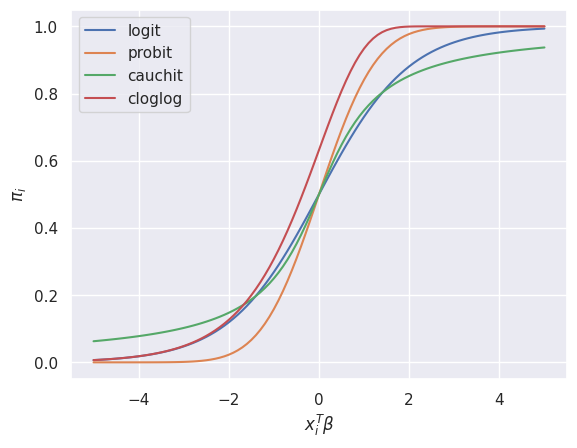

In [ ]:
x = np.tile(np.linspace(-5, 5, 101), 4).reshape(4, -1)
y = []
names =[]

for i, j in enumerate(zip(("logit", "probit", "cauchit", "cloglog"),
                (sm.genmod.families.links.Logit(), sm.genmod.families.links.probit(),
                 sm.genmod.families.links.cauchy(), sm.genmod.families.links.CLogLog()))):

    y.append(j[1].inverse(x[i]))
    names.append([j[0]]*len(x[i]))

y = np.array(y).flatten()
n = np.array(names).flatten()

fig, ax = plt.subplots()



sns.lineplot(x='x', y='y', data=pd.DataFrame(data={'x': x.flatten(), 'y': y, 'n': n}), ax=ax, hue='n')


ax.legend()
ax.set_xlabel(r'$x_i^T \beta$')
ax.set_ylabel(r'$\pi_i$')
plt.show()

## Logistic regression with Titanic dataset

https://www.kaggle.com/c/titanic/data

| Variable |                 Definition                 |                       Key                      |
|:--------:|:------------------------------------------:|:----------------------------------------------:|
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                              |                                                |
| fare     | Passenger fare                             |                                                |
| cabin    | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

In [ ]:
X, y = datasets.fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

titanic_train = pd.concat([X_train, y_train], axis=1)
titanic_test = pd.concat([X_test, y_test], axis=1)

In [ ]:
titanic_test.describe(include = 'all')

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
count,262.000000,262,262,203.000000,262.000000,262.000000,262,262.000000,62,261,96,17.000000,142,262
unique,NaN,262,2,NaN,NaN,NaN,238,NaN,54,3,22,NaN,110,2
top,NaN,"Panula, Mr. Ernesti Arvid",male,NaN,NaN,NaN,347088,NaN,G6,S,5,NaN,"New York, NY",0
freq,NaN,1,158,NaN,NaN,NaN,3,NaN,3,186,9,NaN,13,162
mean,2.305344,NaN,NaN,30.841954,0.473282,0.427481,NaN,30.445739,NaN,NaN,NaN,150.117647,NaN,NaN
std,0.852251,NaN,NaN,14.442503,1.015800,1.002147,NaN,41.713266,NaN,NaN,NaN,100.003051,NaN,NaN
min,1.000000,NaN,NaN,0.666700,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN
25%,1.000000,NaN,NaN,22.000000,0.000000,0.000000,NaN,7.903100,NaN,NaN,NaN,52.000000,NaN,NaN
50%,3.000000,NaN,NaN,28.500000,0.000000,0.000000,NaN,14.500000,NaN,NaN,NaN,126.000000,NaN,NaN
75%,3.000000,NaN,NaN,41.000000,1.000000,0.000000,NaN,31.471875,NaN,NaN,NaN,232.000000,NaN,NaN


# Fast and furios solution of the HW from the previous Ex07

Consider a model with continuos variables `age`, `fare`, and any factor variable.

* Create factor `age`, which takes values 1 (child) and 0 (adult).
* Create factor from varaible `fare` by spliting into 10 groups with approx same number of observations.
* What percentage is the chance of survival lower for adult compare to child?
* Depends the probability of survival on fare? Test it.
* Assume that the chance of survival increases with exponential increasig fare. How the chance of survival increased if the person spent an extra 10 pound for a ticket?
* Build a model where the probabilty of survival depends on both `age` and `fare`. Are both covariates significant?
*

In [ ]:
data_HW = titanic_train >> \
  select(titanic_train.survived,titanic_train.age,titanic_train.fare,titanic_train.pclass,titanic_train.sex,
         titanic_train.embarked)

data_HW = data_HW.apply(lambda x: x.astype('category') if str(x.dtype) == 'str' else x)
#print(data_HW.describe(include='all'))
#print(data_HW.dtypes)

data_HW = data_HW >> \
            filter_by(data_HW.embarked.isin(('C', 'S', 'Q')) )  >> \
            transmute(survived = data_HW.survived.astype('category'),
                      survived_num = data_HW.survived.astype('float'),
                      age = pd.cut(data_HW.age,(-np.inf, 16, np.inf), labels=["child","adult"]),
                      age_num = data_HW.age,
                      fare = data_HW.fare,
                      fare_quantile = pd.qcut(data_HW.fare, q=8, labels=list(range(1, 9))),
                      fare_quantile2 = pd.qcut(data_HW.fare, q=np.linspace(0, 1, 7)),
                      class_ = data_HW.pclass.astype('category'),
                      sex = data_HW.sex.astype('category'),
                      embarked = data_HW.embarked.astype('category'))

# Create binary (int64) age factor: 1 if child, 0 if adult
data_HW['age_binary'] = np.where(data_HW['age'] == 'child', 1, 0)

# Create fare (float64) by splitting into 8 groups with approx equal observations
data_HW['fare_group'] = pd.qcut(data_HW['fare'], 8, labels=False)

data_HW = data_HW.dropna(axis=0, how='any')  # `axis=0` stands for per index (row)

# Check Dtypes
print(data_HW.info())

data_HW.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
Index: 841 entries, 995 to 723
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   survived        841 non-null    category
 1   survived_num    841 non-null    float64 
 2   age             841 non-null    category
 3   age_num         841 non-null    float64 
 4   fare            841 non-null    float64 
 5   fare_quantile   841 non-null    category
 6   fare_quantile2  841 non-null    category
 7   class_          841 non-null    category
 8   sex             841 non-null    category
 9   embarked        841 non-null    category
 10  age_binary      841 non-null    int64   
 11  fare_group      841 non-null    float64 
dtypes: category(7), float64(4), int64(1)
memory usage: 46.4 KB
None


,survived,survived_num,age,age_num,fare,fare_quantile,fare_quantile2,class_,sex,embarked,age_binary,fare_group
count,841,841.000000,841,841.000000,841.000000,841.0,841,841.0,841,841,841.000000,841.000000
unique,2,NaN,2,NaN,NaN,8.0,6,3.0,2,3,NaN,NaN
top,0,NaN,adult,NaN,NaN,3.0,"(8.662, 14.427]",3.0,male,S,NaN,NaN
freq,504,NaN,733,NaN,NaN,135.0,158,402.0,538,632,NaN,NaN
mean,NaN,0.400713,NaN,29.574614,37.263941,NaN,NaN,NaN,NaN,NaN,0.128419,3.673008
std,NaN,0.490335,NaN,14.339745,57.915241,NaN,NaN,NaN,NaN,NaN,0.334754,2.287408
min,NaN,0.000000,NaN,0.166700,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,0.000000,NaN,21.000000,8.050000,NaN,NaN,NaN,NaN,NaN,0.000000,2.000000
50%,NaN,0.000000,NaN,28.000000,15.550000,NaN,NaN,NaN,NaN,NaN,0.000000,4.000000
75%,NaN,1.000000,NaN,38.000000,34.375000,NaN,NaN,NaN,NaN,NaN,0.000000,6.000000


In [ ]:
# Simple Logistic Regression model with all discrete covariates fare,sex, agewithout interactions
mod_HW1=smf.glm(formula = 'survived_num~age+sex+fare_quantile2', data=data_HW,
                family=sm.families.Binomial(sm.families.links.Logit())).fit()

print(mod_HW1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           survived_num   No. Observations:                  841
Model:                            GLM   Df Residuals:                      833
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -407.33
Date:                Tue, 29 Apr 2025   Deviance:                       814.67
Time:                        18:22:55   Pearson chi2:                     822.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.3147
Covariance Type:            nonrobust                                         
                                                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

In [ ]:
#Function to estimate OR with lower and upper limit of 95% CI for OR

def OR_coef(variable,model,CI):
    param = np.array(model.params)
    where = np.where(np.array(model.params.index) == variable)
    beta = param[where]
    se = np.sqrt(np.diag(model.cov_params().to_numpy()))[where]
    or_ = np.exp(beta)

    return pd.DataFrame(index=[variable], data={'OR': or_, 'LCL': np.exp(beta-1*scipy.stats.norm.ppf(CI/2 +0.5)*se)
                                              , 'UCL':np.exp(beta+ scipy.stats.norm.ppf(CI/2 +0.5)*se)})
OR_coef("age[T.adult]",mod_HW1,0.95)

,OR,LCL,UCL
age[T.adult],0.631642,0.383206,1.041144


The chances of drowning were almost twice as high in the group of adults as in the group of children.

In [ ]:
# Check model with factorized Fare
mod_HW0=smf.glm(formula = 'survived_num~age+sex', data=data_HW,
                family=sm.families.Binomial(sm.families.links.Logit())).fit()
mod_HW1=smf.glm(formula = 'survived_num~age+sex+fare_quantile2', data=data_HW,
                family=sm.families.Binomial(sm.families.links.Logit())).fit()
mod_HW2=smf.glm(formula = 'survived_num~age+sex+fare', data=data_HW,
                family=sm.families.Binomial(sm.families.links.Logit())).fit()

print(mod_HW1.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:           survived_num   No. Observations:                  841
Model:                            GLM   Df Residuals:                      833
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -407.33
Date:                Tue, 29 Apr 2025   Deviance:                       814.67
Time:                        18:22:56   Pearson chi2:                     822.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.3147
Covariance Type:            nonrobust                                         
                                                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

Yes, covariate `fare` is statisticaly significant in the model. But it's better to test it with Deviation test (LRT) compare to Wald tests from summary() function.

In [ ]:
anova = Anova()
anova(mod_HW1,mod_HW0,test="Chisq")

,resid_df,resid_deviance,df,deviance,chi2,p_val
0,833,814.669394,NaN,NaN,NaN,NaN
1,838,868.622323,-5.0,-53.952929,53.952929,2.143034e-10


Confirmed.

In [ ]:
# Fare as continuous variable

mod_HW3 = smf.glm(formula = 'survived_num~np.divide(fare, 10)', data=data_HW,
                family=sm.families.Binomial(sm.families.links.Logit())).fit()
mod_HW4 = smf.glm(formula = 'survived_num~np.divide(fare, 10)+sex+age', data=data_HW,
                family=sm.families.Binomial(sm.families.links.Logit())).fit()

print(mod_HW4.summary())
print("mod_HW3 ---------")
print(np.exp(mod_HW3.params))
print("mod_HW4 ---------")
print(np.exp(mod_HW4.params))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           survived_num   No. Observations:                  841
Model:                            GLM   Df Residuals:                      837
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -416.65
Date:                Tue, 29 Apr 2025   Deviance:                       833.31
Time:                        18:22:56   Pearson chi2:                     823.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2993
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.1214    

The chance of survival increased by 10% with the ticket price 10 pounds higher.

Question: What can you say about Causality? Does a higher price result in a greater chance of survival?



In [ ]:
# Model without sex variable
mod_HW5 = smf.glm(formula = 'survived_num~np.divide(fare, 10)+np.divide(age_num, 10)', data=data_HW,
                family=sm.families.Binomial(sm.families.links.Logit())).fit()

print(mod_HW5.summary())
print(np.exp(mod_HW5.params))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           survived_num   No. Observations:                  841
Model:                            GLM   Df Residuals:                      838
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -529.62
Date:                Tue, 29 Apr 2025   Deviance:                       1059.2
Time:                        18:22:56   Pearson chi2:                     866.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08340
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

## Binomial data approach

In [ ]:
data_HW_bin = \
        (data_HW.groupby(by=["sex", "age", "fare_quantile2"], as_index=False)
        .agg(n=('survived_num', 'count'), m=('survived_num', 'sum'))

    )


<ipython-input-15-75d94e003ea8>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (data_HW.groupby(by=["sex", "age", "fare_quantile2"], as_index=False)


In [ ]:
data_HW_bin

,sex,age,fare_quantile2,n,m
0,female,child,"(-0.001, 7.775]",3,3.0
1,female,child,"(7.775, 8.662]",3,2.0
2,female,child,"(8.662, 14.427]",7,4.0
3,female,child,"(14.427, 26.0]",15,10.0
4,female,child,"(26.0, 53.1]",18,10.0
5,female,child,"(53.1, 512.329]",2,2.0
6,female,adult,"(-0.001, 7.775]",21,12.0
7,female,adult,"(7.775, 8.662]",18,6.0
8,female,adult,"(8.662, 14.427]",46,36.0
9,female,adult,"(14.427, 26.0]",51,35.0


### Some additional questions

**Estimate** null model and compare obtained probality of survived with estimated probability from survived-not survived ratio.

In [ ]:
data_HW_bin['f'] = data_HW_bin['n'] - data_HW_bin['m']
data_HW_bin = sm.add_constant(data_HW_bin)

mod_0 = sm.GLM(endog =data_HW_bin[['m', 'f']], exog=data_HW_bin['const'],
                family=sm.families.Binomial(sm.families.links.Logit())).fit()

print(mod_0.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:             ['m', 'f']   No. Observations:                   24
Model:                            GLM   Df Residuals:                       23
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -221.97
Date:                Tue, 29 Apr 2025   Deviance:                       373.56
Time:                        18:22:56   Pearson chi2:                     330.
No. Iterations:                     4   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4025      0.070     -5.720      0.0

In [ ]:
def invlogit(x): return np.exp(x) / (1+np.exp(x)) # inverse logit function
p0_model = invlogit(mod_0.params)

# Probability of survive
p0_stat = data_HW_bin['m'].sum()/data_HW_bin['n'].sum()
print(p0_model)
print(p0_stat)
print("-------")
# Chance of survive
print(np.exp(mod_0.params))
print(p0_stat/(1-p0_stat))

const    0.400713
dtype: float64
0.40071343638525564
-------
const    0.668651
dtype: float64
0.6686507936507936


In [ ]:
data_HW_bin

,const,sex,age,fare_quantile2,n,m,f
0,1.0,female,child,"(-0.001, 7.775]",3,3.0,0.0
1,1.0,female,child,"(7.775, 8.662]",3,2.0,1.0
2,1.0,female,child,"(8.662, 14.427]",7,4.0,3.0
3,1.0,female,child,"(14.427, 26.0]",15,10.0,5.0
4,1.0,female,child,"(26.0, 53.1]",18,10.0,8.0
5,1.0,female,child,"(53.1, 512.329]",2,2.0,0.0
6,1.0,female,adult,"(-0.001, 7.775]",21,12.0,9.0
7,1.0,female,adult,"(7.775, 8.662]",18,6.0,12.0
8,1.0,female,adult,"(8.662, 14.427]",46,36.0,10.0
9,1.0,female,adult,"(14.427, 26.0]",51,35.0,16.0


In [ ]:
# formula setup for a binomial model when you have counts of successes (m) and data_HW_bin(f)
mod_00 = smf.glm(formula='m + f ~ 1', data=data_HW_bin, family=sm.families.Binomial()).fit()

# Print the summary of the model
print(mod_00.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             ['m', 'f']   No. Observations:                   24
Model:                            GLM   Df Residuals:                       23
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -221.97
Date:                Tue, 29 Apr 2025   Deviance:                       373.56
Time:                        18:22:56   Pearson chi2:                     330.
No. Iterations:                     4   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4025      0.070     -5.720      0.0

Estimate model with one covariate factorized `fare` and compare OR computed directly from estimated regression coefficient with OR compputed from probabilities of survived for each group.

In [ ]:
#mod_fare = sm.GLM(endog =data_HW_bin[['m', 'f']], exog=data_HW_bin[['const', 'fare_quantile2']],
#                family=sm.families.Binomial(sm.families.links.Logit())).fit()

#mod_fare = smf.glm('(m,f) ~ fare_quantile2', data=data_HW_bin,
#                family=sm.families.Binomial(sm.families.links.Logit())).fit()

# above are not working so we need to use var_weights approach
data_HW_bin['p'] = data_HW_bin['m'] / data_HW_bin['n']

mod_fare = smf.glm(formula = 'p ~ fare_quantile2', data=data_HW_bin, var_weights=data_HW_bin['n'],
              family=sm.families.Binomial(sm.families.links.Logit())).fit()



print(mod_fare.summary())
#mod_fare.summary()
anova = Anova()
display(anova(mod_fare,mod_0,test="Chisq"))

# Fare price is highly significant in the model.
print(np.exp(mod_fare.params))




                 Generalized Linear Model Regression Results                  
Dep. Variable:                      p   No. Observations:                   24
Model:                            GLM   Df Residuals:                       18
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -396.52
Date:                Tue, 29 Apr 2025   Deviance:                       273.51
Time:                        18:22:56   Pearson chi2:                     255.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9845
Covariance Type:            nonrobust                                         
                                                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

,resid_df,resid_deviance,df,deviance,chi2,p_val
0,18,273.509820,NaN,NaN,NaN,NaN
1,23,373.557596,-5.0,-100.047776,100.047776,5.164018e-20


Intercept                                                    0.302326
fare_quantile2[T.Interval(7.775, 8.662, closed='right')]     0.819048
fare_quantile2[T.Interval(8.662, 14.427, closed='right')]    1.766243
fare_quantile2[T.Interval(14.427, 26.0, closed='right')]     2.339587
fare_quantile2[T.Interval(26.0, 53.1, closed='right')]       2.559524
fare_quantile2[T.Interval(53.1, 512.329, closed='right')]    8.043706
dtype: float64


Question: Assume you spent 25 pounds for a ticket. What is your chance to survive compare to someone who spent only 5 pounds?

In [ ]:
# Compute probability of survival:
print(invlogit(mod_fare.params[0]) )
invlogit(mod_fare.params[0]+mod_fare.params[1:])

0.23214285714285715


<ipython-input-22-3b8deb195c1b>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(invlogit(mod_fare.params[0]) )
<ipython-input-22-3b8deb195c1b>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  invlogit(mod_fare.params[0]+mod_fare.params[1:])


,0
"fare_quantile2[T.Interval(7.775, 8.662, closed='right')]",0.198473
"fare_quantile2[T.Interval(8.662, 14.427, closed='right')]",0.348101
"fare_quantile2[T.Interval(14.427, 26.0, closed='right')]",0.414286
"fare_quantile2[T.Interval(26.0, 53.1, closed='right')]",0.436242
"fare_quantile2[T.Interval(53.1, 512.329, closed='right')]",0.708609


In [ ]:
# Compute OR of survival:
print(np.exp(mod_fare.params))

Intercept                                                    0.302326
fare_quantile2[T.Interval(7.775, 8.662, closed='right')]     0.819048
fare_quantile2[T.Interval(8.662, 14.427, closed='right')]    1.766243
fare_quantile2[T.Interval(14.427, 26.0, closed='right')]     2.339587
fare_quantile2[T.Interval(26.0, 53.1, closed='right')]       2.559524
fare_quantile2[T.Interval(53.1, 512.329, closed='right')]    8.043706
dtype: float64


In [ ]:
# Compute chance of survival:
print(np.exp(mod_fare.params[0]+mod_fare.params[1:]))

fare_quantile2[T.Interval(7.775, 8.662, closed='right')]     0.247619
fare_quantile2[T.Interval(8.662, 14.427, closed='right')]    0.533981
fare_quantile2[T.Interval(14.427, 26.0, closed='right')]     0.707317
fare_quantile2[T.Interval(26.0, 53.1, closed='right')]       0.773810
fare_quantile2[T.Interval(53.1, 512.329, closed='right')]    2.431818
dtype: float64


<ipython-input-24-215cbcea609d>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(np.exp(mod_fare.params[0]+mod_fare.params[1:]))


In [ ]:
# Check: odds ratio computed by hands.
Pr_1= invlogit(mod_fare.params.iloc[0])
Pr_6 = invlogit(mod_fare.params.iloc[0] +mod_fare.params.iloc[5])

OR_1 = Pr_1/(1-Pr_1)
OR_6 = Pr_6/(1-Pr_6)
print(OR_6/OR_1)
print("----")
print(np.exp(mod_fare.params[5]))
print(np.exp(mod_fare.params[-1]))
print(np.exp(mod_fare.params["fare_quantile2[T.Interval(53.1, 512.329, closed='right')]"]))

8.043706293706283
----
8.04370629370628
8.04370629370628
8.04370629370628


<ipython-input-25-c25f69f9fcae>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(np.exp(mod_fare.params[5]))
<ipython-input-25-c25f69f9fcae>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(np.exp(mod_fare.params[-1]))


**Estimate saturated model**

If we have  fixed number of parameters,  saturated model obtain every  "observation" and residual deviance of this saturated model is "zero".


In [ ]:
mod_HW_sat = smf.glm('p ~ fare_quantile2*age*sex', data=data_HW_bin, var_weights=data_HW_bin['n'],
              family=sm.families.Binomial(sm.families.links.Logit())).fit()

print(mod_HW_sat.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  scale = np.dot(wresid, wresid) / df_resid
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generaliz

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      p   No. Observations:                   24
Model:                            GLM   Df Residuals:                        0
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -259.77
Date:                Tue, 29 Apr 2025   Deviance:                   4.3051e-09
Time:                        18:22:56   Pearson chi2:                 2.15e-09
No. Iterations:                    20   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------


We can test other models against saturated one.

In [ ]:
mod_HW_bin1 = smf.glm('p ~ fare_quantile2+age+sex', data=data_HW_bin, var_weights=data_HW_bin['n'],
              family=sm.families.Binomial(sm.families.links.Logit())).fit()


print(mod_HW_bin1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      p   No. Observations:                   24
Model:                            GLM   Df Residuals:                       16
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -287.63
Date:                Tue, 29 Apr 2025   Deviance:                       55.737
Time:                        18:22:57   Pearson chi2:                     56.3
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

In [ ]:
anova(mod_HW_sat,mod_HW_bin1, test="Chisq")



,resid_df,resid_deviance,df,deviance,chi2,p_val
0,0,4.305058e-09,NaN,NaN,NaN,NaN
1,16,5.573659e+01,-16.0,-55.736591,55.736591,0.000003


## Question:
* How do you interpret previous result?
* Is simplier aditive model without interactions good enough?

## Residual analysis

In [ ]:
# start with simple model
mod_1 = smf.glm('survived_num ~ age_num+sex+class_', data=data_HW,
              family=sm.families.Binomial(sm.families.links.Logit())).fit()


print(mod_1.summary())

#mod_1 = smf.glm('survived_num ~dare+sex+', data=data_HW_bin,
#              family=sm.families.Binomial(sm.families.links.Logit())).fit()
#mod_1.summary()




                 Generalized Linear Model Regression Results                  
Dep. Variable:           survived_num   No. Observations:                  841
Model:                            GLM   Df Residuals:                      836
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -390.12
Date:                Tue, 29 Apr 2025   Deviance:                       780.24
Time:                        18:22:57   Pearson chi2:                     870.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3422
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.3871      0.369      9.189      

In [ ]:
# Combine residuals
residuals_df = pd.DataFrame({
    "response": mod_1.resid_response,
    "working": mod_1.resid_working,
    "pearson": mod_1.resid_pearson,
    "deviance": mod_1.resid_deviance
})

print(residuals_df.head())

     response   working   pearson  deviance
995 -0.075916 -1.082153 -0.286623 -0.397372
753 -0.106825 -1.119602 -0.345835 -0.475338
215 -0.294143 -1.416717 -0.645536 -0.834676
670 -0.096289 -1.106549 -0.326418 -0.449991
732 -0.086692 -1.094920 -0.308091 -0.425868


<Axes: title={'center': 'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>

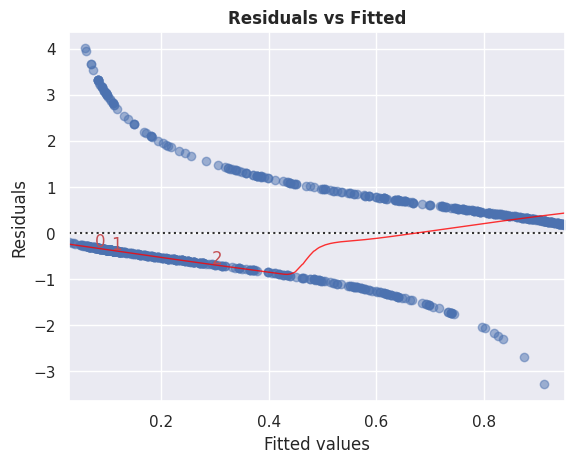

In [ ]:
cls = DiagnosticPlots(mod_1)
cls.residual_plot()

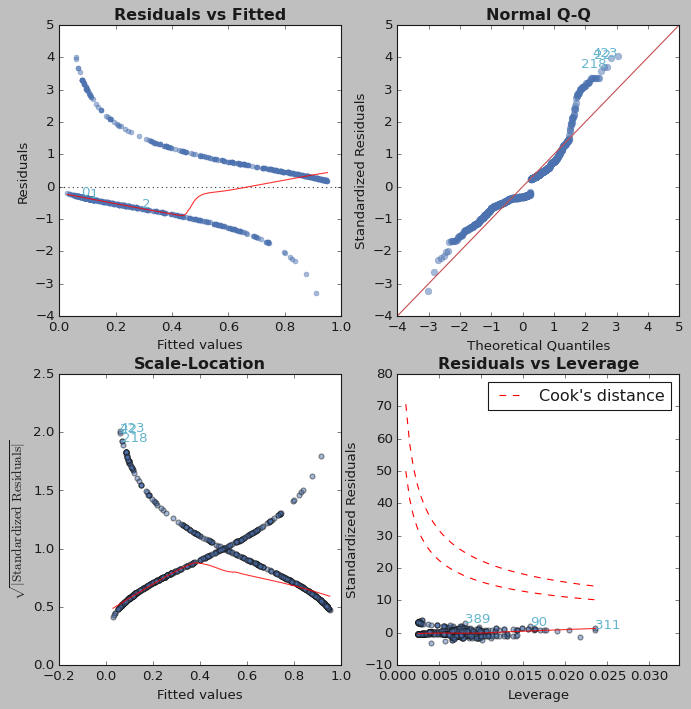

      Features  VIF Factor
1  sex[T.male]        1.04
4      age_num        1.27
2  class_[T.2]        1.62
3  class_[T.3]        1.89
0    Intercept       13.93


In [ ]:
# print(plt.style.available)
fig, ax = cls(plot_context='classic')

### Diagnostic plots without custom class

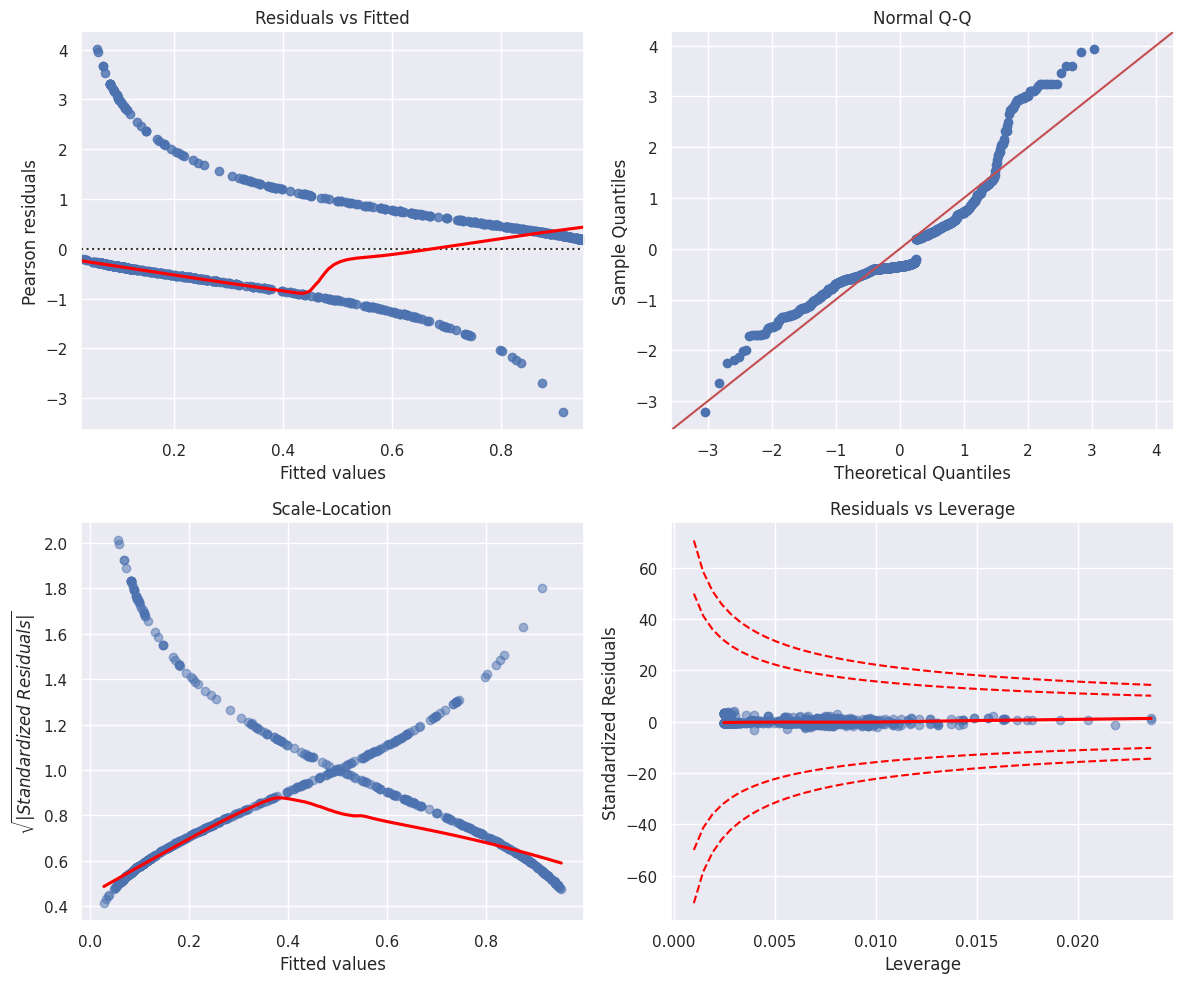

In [ ]:
# Compute diagnostics
influence = mod_1.get_influence()
resid = mod_1.resid_pearson
resid_studentized = influence.resid_studentized
fitted = mod_1.fittedvalues
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]

# Plot Residuals vs Fitted
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.residplot(x=fitted, y=resid, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Fitted values")
plt.ylabel("Pearson residuals")
plt.title("Residuals vs Fitted")

# Q-Q Plot
plt.subplot(2, 2, 2)
qqplot(resid_studentized, line='45', fit=True, ax=plt.gca())
plt.title("Normal Q-Q")

# Scale-Location Plot
plt.subplot(2, 2, 3)
resid_sqrt = np.sqrt(np.abs(resid_studentized))
plt.scatter(fitted, resid_sqrt, alpha=0.5)
sns.regplot(x=fitted, y=resid_sqrt, lowess=True, scatter=False, line_kws={'color': 'red'})
plt.xlabel("Fitted values")
plt.ylabel(r"$\sqrt{|Standardized\ Residuals|}$")
plt.title("Scale-Location")

# Residuals vs Leverage with Cook's distance
plt.subplot(2, 2, 4)
plt.scatter(leverage, resid_studentized, alpha=0.5)
sns.regplot(x=leverage, y=resid_studentized, lowess=True, scatter=False, line_kws={'color': 'red'})
plt.xlabel("Leverage")
plt.ylabel("Standardized Residuals")
plt.title("Residuals vs Leverage")

# Add Cook's distance contours
def cooks_dist_line(factor):
    p = mod_1.df_model + 1
    x = np.linspace(0.001, max(leverage), 50)
    y = np.sqrt(factor * p * (1 - x) / x)
    return x, y

for val in [0.5, 1]:
    x_line, y_line = cooks_dist_line(val)
    plt.plot(x_line, y_line, linestyle='--', color='red')
    plt.plot(x_line, -y_line, linestyle='--', color='red')

plt.tight_layout()
plt.show()


A perfect fit of a datapoint (which never occurs) gives a deviance of zero as "log(1) =0". A poorly fitting point has a large residual deviance.

All plots look funny. What do you think, is there any problem in the model?


* The **Residuals vs Fitted** plot can help you see, for example, if there are curvilinear trends that you missed. But the fit of a logistic regression is curvilinear by nature, so you can have odd looking trends in the residuals with nothing amiss.
* The **Normal Q-Q** plot helps you detect if your residuals are normally distributed. But the deviance residuals don't have to be normally distributed for the model to be valid, so the normality / non-normality of the residuals doesn't necessarily tell you anything.
* The **Scale-Location** plot can help you identify heteroscedasticity. But logistic regression models are pretty much heteroscedastic by nature.
* The **Residuals vs Leverage** can help you identify possible outliers. But outliers in logistic regression don't necessarily manifest in the same way as in linear regression, so this plot may or may not be helpful in identifying them.

source:https://stats.stackexchange.com/questions/121490/interpretation-of-plot-glm-model


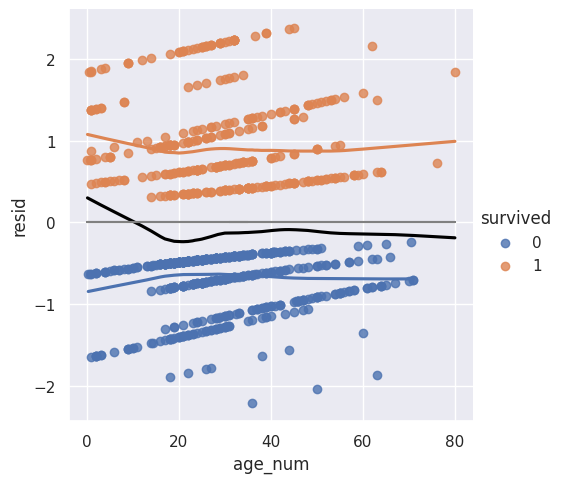

In [ ]:
d = data_HW[['age_num', 'survived']].copy()
d['resid'] = mod_1.resid_deviance

sns.lmplot(x='age_num', y='resid', data=d, hue='survived', lowess=True)
sns.regplot(x='age_num', y='resid', data=d, lowess=True, color='black', marker='')
plt.plot(d['age_num'], np.zeros((len(d['age_num']),)), color='grey')

In [ ]:
data_HW_mod = data_HW >> \
        mutate(fitted=mod_1.fittedvalues,
               predict = np.where(mod_1.fittedvalues.to_numpy() > 0.5, '1', '0'), # default threshold 0.5
               r_deviance_std = mod_1.resid_deviance,  # standardized by default
               r_pearson_std = mod_1.resid_pearson  # standardized by default
              )
data_HW_mod['predict'] = data_HW_mod['predict'].astype('category')
data_HW_mod.head()

,survived,survived_num,age,age_num,fare,fare_quantile,fare_quantile2,class_,sex,embarked,age_binary,fare_group,fitted,predict,r_deviance_std,r_pearson_std
995,0,0.0,adult,35.0,7.8958,2,"(7.775, 8.662]",3,male,C,0,1.0,0.075916,0,-0.397372,-0.286623
753,0,0.0,adult,22.0,8.0500,3,"(7.775, 8.662]",3,male,S,0,2.0,0.106825,0,-0.475338,-0.345835
215,0,0.0,adult,58.0,113.2750,8,"(53.1, 512.329]",1,male,C,0,7.0,0.294143,0,-0.834676,-0.645536
670,0,0.0,adult,26.0,7.7750,2,"(-0.001, 7.775]",3,male,S,0,1.0,0.096289,0,-0.449991,-0.326418
732,0,0.0,adult,30.0,8.0500,3,"(7.775, 8.662]",3,male,S,0,2.0,0.086692,0,-0.425868,-0.308091


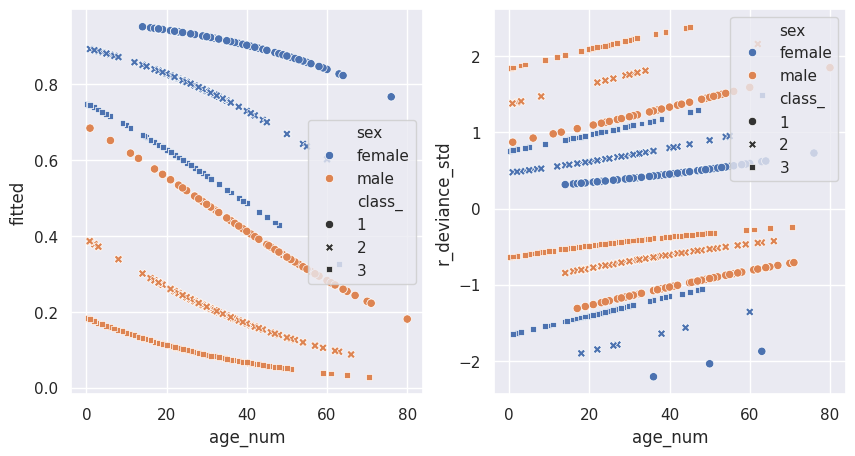

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x='age_num', y='fitted', data=data_HW_mod, hue='sex', style='class_', ax=ax[0])
sns.scatterplot(x='age_num', y='r_deviance_std', data=data_HW_mod, hue='sex', style='class_', ax=ax[1])
plt.show()

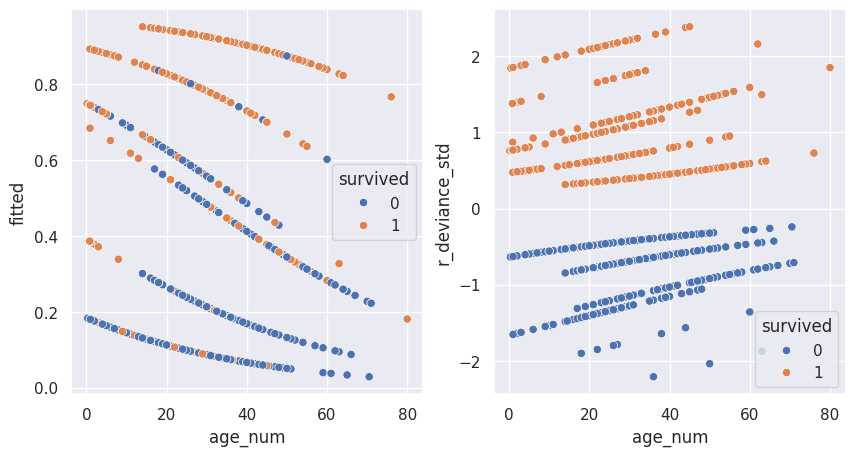

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x='age_num', y='fitted', data=data_HW_mod, hue='survived', ax=ax[0])
sns.scatterplot(x='age_num', y='r_deviance_std', data=data_HW_mod, hue='survived', ax=ax[1])
plt.show()

## Post hoc analysis by quality of fitted values

In [ ]:
# Fit a  model
pd.crosstab([data_HW_mod.predict],[data_HW.survived])

survived,0,1
predict,,
0,429,100
1,75,237


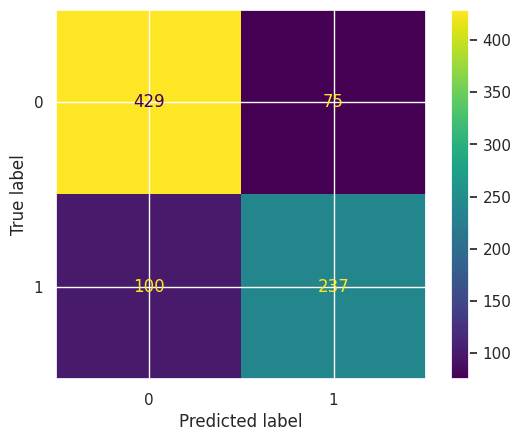

In [ ]:
ConfusionMatrixDisplay.from_predictions(data_HW_mod.survived, data_HW_mod.predict)
plt.show()

https://en.wikipedia.org/wiki/Precision_and_recall

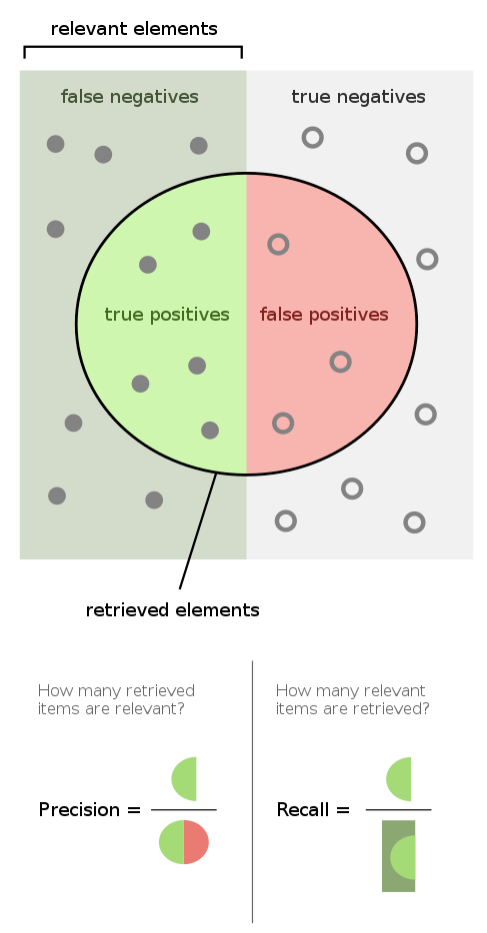

https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers

In [ ]:
print(confusion_matrix(y_true=data_HW_mod.survived, y_pred=data_HW_mod.predict))

[[429  75]
 [100 237]]


In [ ]:
print(classification_report(y_true=data_HW_mod.survived, y_pred=data_HW_mod.predict))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       504
           1       0.76      0.70      0.73       337

    accuracy                           0.79       841
   macro avg       0.79      0.78      0.78       841
weighted avg       0.79      0.79      0.79       841



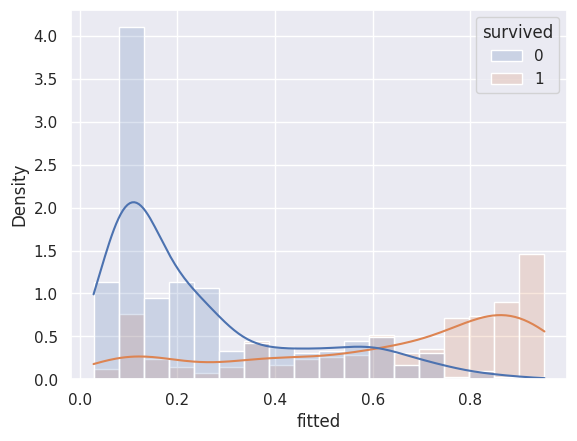

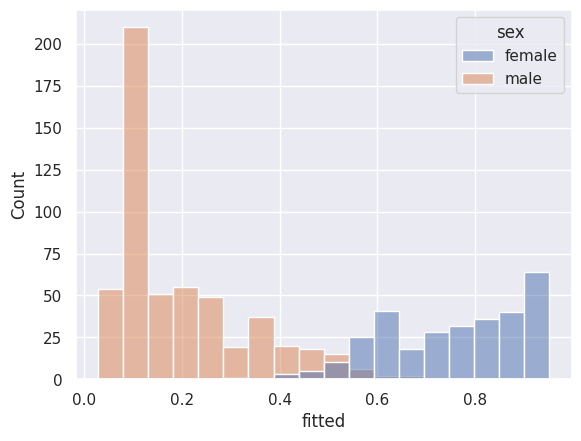

In [ ]:
sns.histplot(data=data_HW_mod, x='fitted', hue='survived', alpha=0.2, fill=True, stat='density', kde=True,
            binwidth=0.05)
plt.show()

sns.histplot(data=data_HW_mod, x='fitted', hue='sex', alpha=0.5, fill=True, stat='count', binwidth=0.05)
plt.show()

In [ ]:
data_HW_mod = data_HW_mod >> \
        mutate(
               predict_04 = np.where(mod_1.fittedvalues.to_numpy() > 0.4, '1', '0'),
              )
data_HW_mod['predict_04'] = data_HW_mod['predict_04'].astype('category')

print(data_HW_mod.head())
print(print(confusion_matrix(y_true=data_HW_mod.survived, y_pred=data_HW_mod.predict_04)))

    survived  survived_num    age  age_num      fare fare_quantile  \
995        0           0.0  adult     35.0    7.8958             2   
753        0           0.0  adult     22.0    8.0500             3   
215        0           0.0  adult     58.0  113.2750             8   
670        0           0.0  adult     26.0    7.7750             2   
732        0           0.0  adult     30.0    8.0500             3   

      fare_quantile2 class_   sex embarked  age_binary  fare_group    fitted  \
995   (7.775, 8.662]      3  male        C           0         1.0  0.075916   
753   (7.775, 8.662]      3  male        S           0         2.0  0.106825   
215  (53.1, 512.329]      1  male        C           0         7.0  0.294143   
670  (-0.001, 7.775]      3  male        S           0         1.0  0.096289   
732   (7.775, 8.662]      3  male        S           0         2.0  0.086692   

    predict  r_deviance_std  r_pearson_std predict_04  
995       0       -0.397372      -0.286623

In [ ]:
(392+265)/(392 + 265 + 104+ 73 ) # Accuracy from Confusion Matrix

0.7877697841726619

## Use test data

In [ ]:
titanic_test.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
1074,3,"O'Connor, Mr. Patrick",male,NaN,0,0,366713,7.7500,NaN,Q,NaN,NaN,NaN,0
268,1,"Smith, Mr. Lucien Philip",male,24.0,1,0,13695,60.0000,C31,S,NaN,NaN,"Huntington, WV",0
8,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY",1
267,1,"Smith, Mr. James Clinch",male,56.0,0,0,17764,30.6958,A7,C,NaN,NaN,"St James, Long Island, NY",0
1015,3,"Meo, Mr. Alfonzo",male,55.5,0,0,A.5. 11206,8.0500,NaN,S,NaN,201.0,NaN,0


In [ ]:
data_test = titanic_test[['age', 'sex', 'pclass', 'fare', 'embarked']] >> \
            filter_by(titanic_test.embarked.isin(('C', 'S', 'Q')) )  >> \
            transmute(survived = titanic_test.survived,
                      survived_num = titanic_test.survived.astype('float'),
                      age = pd.cut(titanic_test.age,(-np.inf, 16, np.inf), labels=["child","adult"]),
                      age_num = titanic_test.age,
                      fare = titanic_test.fare,
                      fare_quantile = pd.qcut(titanic_test.fare, q=8, labels=list(range(1, 9))),
                      fare_quantile2 = pd.qcut(titanic_test.fare, q=np.linspace(0, 1, 9)),
                      class_ = titanic_test.pclass.astype('category'),
                      sex = titanic_test.sex.astype('category'),
                      embarked = titanic_test.embarked.astype('category'))

data_test = data_test.dropna(axis=0, how='any')  # `axis=0` stands for per index (row)
print(data_test.describe(include='all'))
print(data_test.info())
#data_test.head()

       survived  survived_num    age     age_num        fare  fare_quantile  \
count       202    202.000000    202  202.000000  202.000000          202.0   
unique        2           NaN      2         NaN         NaN            8.0   
top           0           NaN  adult         NaN         NaN            4.0   
freq        114           NaN    176         NaN         NaN           31.0   
mean        NaN      0.435644    NaN   30.806518   33.851383            NaN   
std         NaN      0.497073    NaN   14.469536   45.690993            NaN   
min         NaN      0.000000    NaN    0.666700    0.000000            NaN   
25%         NaN      0.000000    NaN   22.000000    8.050000            NaN   
50%         NaN      0.000000    NaN   28.250000   16.400000            NaN   
75%         NaN      1.000000    NaN   41.000000   38.437500            NaN   
max         NaN      1.000000    NaN   74.000000  263.000000            NaN   

       fare_quantile2  class_   sex embarked  
coun

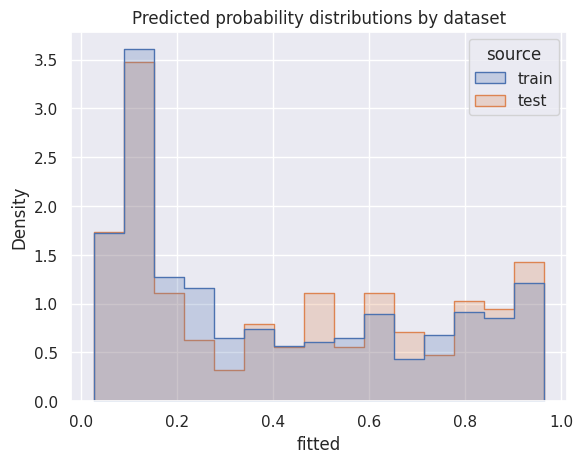

In [ ]:
# Compute predictions for the test set
data_test_mod = data_test.copy()
data_test_mod['fitted'] = mod_1.predict(data_test_mod)
data_test_mod['predict'] = np.where(data_test_mod['fitted'] > 0.5, '1', '0')
data_test_mod['predict'] = data_test_mod['predict'].astype('category')
data_test_mod['r_deviance_std'] = np.nan  # not available for out-of-sample
data_test_mod['r_pearson_std'] = np.nan   # not available for out-of-sample
data_test_mod['source'] = 'test'

# Add source column to training set
data_HW_mod['source'] = 'train'

# Combine into one dataframe
data_combined = pd.concat([data_HW_mod, data_test_mod], axis=0)

# Split by dataset (train/test)
sns.histplot(data=data_combined, x='fitted', hue='source',
             element='step', common_norm=False, stat='density', bins=15)
plt.title("Predicted probability distributions by dataset")
plt.show()



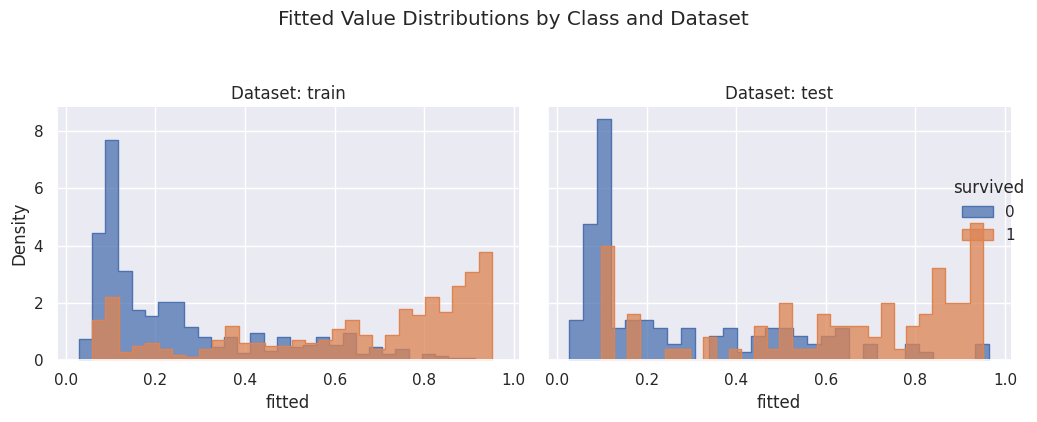

In [ ]:
g = sns.FacetGrid(data_combined, col='source', hue='survived', height=4, aspect=1.2)
g.map(sns.histplot, 'fitted', stat='density', element='step', bins=30)
g.add_legend()
g.set_titles("Dataset: {col_name}")
plt.suptitle("Fitted Value Distributions by Class and Dataset", y=1.05)
plt.tight_layout()
plt.show()


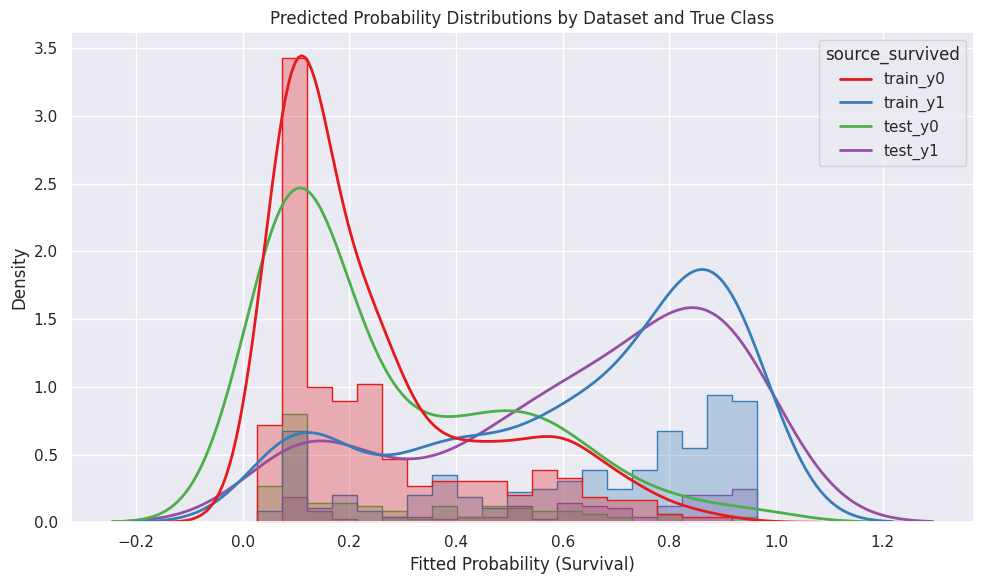

In [ ]:
# Create a combined label for hue
data_combined['source_survived'] = data_combined['source'].astype(str) + "_y" + data_combined['survived'].astype(str)
plt.figure(figsize=(10, 6))

# Histogram
sns.histplot(
    data=data_combined,
    x='fitted',
    hue='source_survived',
    multiple='layer',
    stat='density',
    bins=20,
    palette='Set1',
    alpha=0.3,
    element='step'
)

# KDE (smoothed version)
sns.kdeplot(
    data=data_combined,
    x='fitted',
    hue='source_survived',
    common_norm=False,
    palette='Set1',
    lw=2
)

plt.title("Predicted Probability Distributions by Dataset and True Class")
plt.xlabel("Fitted Probability (Survival)")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


    survived  survived_num    age  age_num     fare fare_quantile  \
427        1           1.0  child   0.6667  14.5000             4   
657        1           1.0  child   0.7500  19.2583             5   
478        1           1.0  child   1.0000  41.5792             7   
826        0           0.0  child   1.0000  46.9000             7   
895        1           1.0  child   1.0000  11.1333             4   

       fare_quantile2 class_     sex embarked    fitted predict  
427     (9.498, 14.5]      2    male        S  0.387415       0  
657    (14.5, 25.496]      3  female        C  0.745941       1  
478  (31.472, 59.625]      2  female        C  0.892727       1  
826  (31.472, 59.625]      3    male        S  0.179923       0  
895     (9.498, 14.5]      3  female        S  0.744570       1  


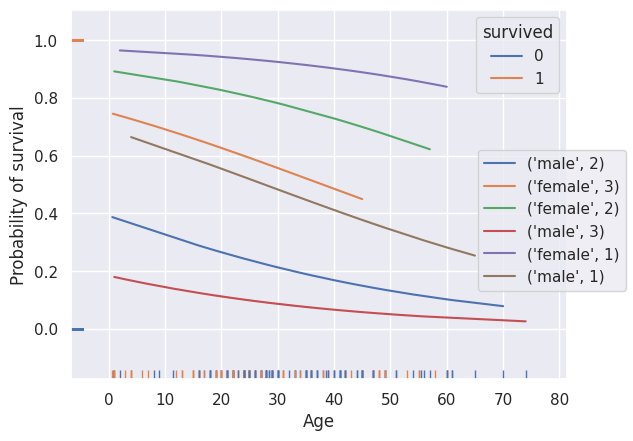

In [ ]:
data_test = data_test >> \
        mutate(fitted=mod_1.predict(exog = data_test, linear=False),
               predict = np.where(mod_1.predict(exog = data_test, linear=False).to_numpy() > 0.5, '1', '0')
              ) >> \
        arrange(data_test.age_num)

data_test['predict'] = data_test['predict'].astype('category')
print(data_test.head())

fig, ax = plt.subplots()
sns.lineplot(data=data_test, x='age_num', y='fitted', hue=data_test[['sex', 'class_']].apply(tuple, axis=1), ax=ax)
sns.rugplot(data=data_test, x='age_num', y='survived_num', hue='survived', ax=ax)

ax.set_xlabel('Age')
ax.set_ylabel('Probability of survival')
fig.legend(loc='center right')


plt.show()

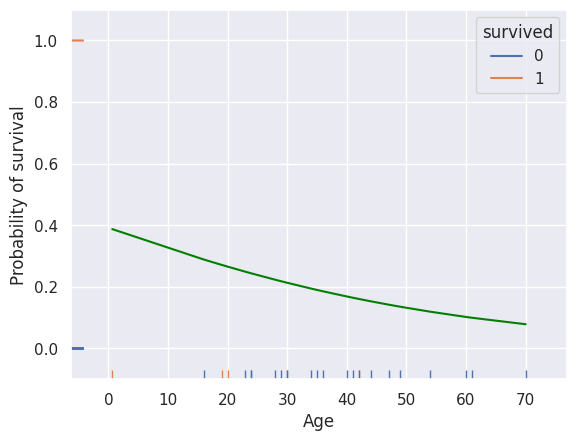

In [ ]:
data_test_select = data_test[(data_test.sex == 'male') & (data_test.class_ == 2)]

fig, ax = plt.subplots()
sns.lineplot(data=data_test_select, x='age_num', y='fitted', ax=ax, color='green')
sns.rugplot(data=data_test_select, x='age_num', y='survived_num', hue='survived', ax=ax)

ax.set_xlabel('Age')
ax.set_ylabel('Probability of survival')

plt.show()

In [ ]:
print(mod_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           survived_num   No. Observations:                  841
Model:                            GLM   Df Residuals:                      836
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -390.12
Date:                Tue, 29 Apr 2025   Deviance:                       780.24
Time:                        18:23:14   Pearson chi2:                     870.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3422
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.3871      0.369      9.189      

In [ ]:
# unfortunately there is not such parameter to calculate `se.fit` so we need perform calculation by hand
# se_fit for linear predictor not for mu
se_fit = []
for _, row in data_test_select[['age_num']].iterrows():
    vec = np.array([1, 1, 1, 0, row['age_num']])
    se_fit.append(np.sqrt(vec @ mod_1.cov_params().to_numpy() @ vec.T))
se_fit = np.array(se_fit)


### Wrong way to plot confidence interval (student solution from couple of years ago)

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


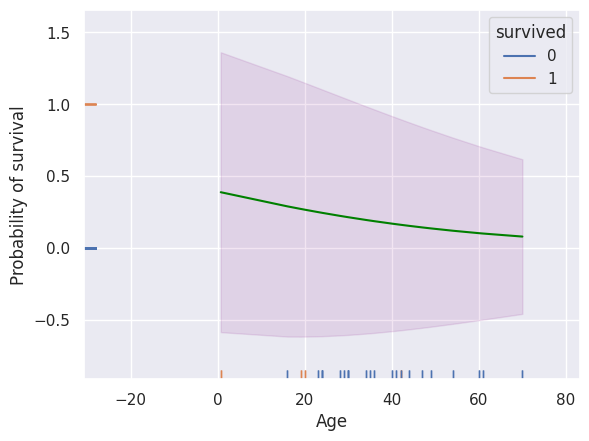

In [ ]:
## Add standard errors and compute a 95% interval the wrong way

# se for nonlinear fit ??
se_fit_w = np.sqrt(mod_1.model.family.variance(mod_1.predict(data_test_select, linear=False)))

data_test_select = data_test_select >> \
  mutate(wrong_se = se_fit_w, #se_fit,
         wrong_upr = data_test_select.fitted + (2 * se_fit_w),
         wrong_lwr = data_test_select.fitted - (2 * se_fit_w))

fig, ax = plt.subplots()
sns.lineplot(data=data_test_select, x='age_num', y='fitted', ax=ax, color='green')
#sns.lineplot(x='age_num', y='wrong_upr', data=data_test_select, ax=ax, color='purple', markers=['-*'])
#sns.lineplot(x='age_num', y='wrong_lwr', data=data_test_select, ax=ax, color='purple', markers=['-*'])
sns.rugplot(data=data_test_select, x='age_num', y='survived_num', hue='survived', ax=ax)

sns.rugplot(data=data_test_select, x='age_num', y='survived_num', hue='survived', ax=ax)

#ax.lines[1].set_linestyle("--")
#ax.lines[2].set_linestyle("--")

plt.fill_between(
        x= data_test_select.age_num,
        y1= data_test_select.wrong_upr,
        y2 =data_test_select.wrong_lwr,
        color= "purple",
        alpha= 0.1)

ax.set_xlabel('Age')
ax.set_ylabel('Probability of survival')

plt.show()

## The Right way

In [ ]:
se_fit  # for linear predictor

array([0.26387983, 0.19947139, 0.19162233, 0.18946577, 0.18448841,
       0.18334923, 0.18334923, 0.18151536, 0.1817479 , 0.18225662,
       0.18225662, 0.18698982, 0.18882234, 0.19090118, 0.20151379,
       0.2046966 , 0.2080728 , 0.2080728 , 0.21536847, 0.2275363 ,
       0.23636639, 0.26052274, 0.29257285, 0.29817074, 0.35099802])

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


    survived  survived_num    age  age_num     fare fare_quantile  \
427        1           1.0  child   0.6667  14.5000             4   
416        0           0.0  child  16.0000  26.0000             6   
503        1           1.0  adult  19.0000  10.5000             4   
520        1           1.0  adult  20.0000  13.8625             4   
447        0           0.0  adult  23.0000  11.5000             4   

       fare_quantile2 class_   sex embarked    fitted predict  wrong_se  \
427     (9.498, 14.5]      2  male        S  0.387415       0  0.487160   
416  (25.496, 31.472]      2  male        S  0.288806       0  0.453208   
503     (9.498, 14.5]      2  male        S  0.271334       0  0.444648   
520     (9.498, 14.5]      2  male        C  0.265660       0  0.441684   
447     (9.498, 14.5]      2  male        S  0.249098       0  0.432491   

     wrong_upr  wrong_lwr  fit_link   se_link       fit    fit_ul    fit_ll  
427   1.361735  -0.586904 -0.458190  0.263880  0.387415 

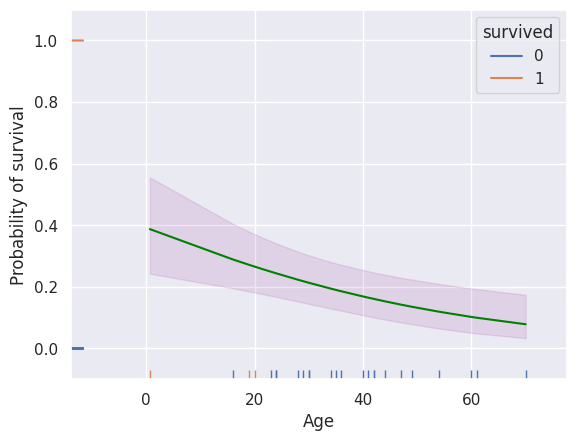

In [ ]:
# Use inverse link function (logit -> probability)
ilink = mod_1.model.family.link.inverse

quant_t = scipy.stats.t.isf(0.025, df =mod_1.df_resid)
quant_n = scipy.stats.norm.isf(0.005)

data_test_select = data_test_select >> \
   mutate(fit_link = mod_1.predict(data_test_select, linear=True),
          se_link  = se_fit,
          fit  = ilink(mod_1.predict(data_test_select, linear=True)),
          fit_ul = ilink(mod_1.predict(data_test_select, linear=True) + (quant_n * se_fit)),
          fit_ll = ilink(mod_1.predict(data_test_select, linear=True) - (quant_n * se_fit)))
## show
print(data_test_select.head())

fig, ax = plt.subplots()
sns.lineplot(data=data_test_select, x='age_num', y='fitted', ax=ax, color='green')
#sns.lineplot(x='age_num', y='fit_ul', data=data_test_select, ax=ax, color='purple', markers=['-*'])
#sns.lineplot(x='age_num', y='fit_ll', data=data_test_select, ax=ax, color='purple', markers=['-*'])
sns.rugplot(data=data_test_select, x='age_num', y='survived_num', hue='survived', ax=ax)

#ax.lines[1].set_linestyle("--")
#ax.lines[2].set_linestyle("--")
plt.fill_between(
        x= data_test_select.age_num,
        y1= data_test_select.fit_ul,
        y2 =data_test_select.fit_ll,
        color= "purple",
        alpha= 0.1)


ax.set_xlabel('Age')
ax.set_ylabel('Probability of survival')


plt.show()


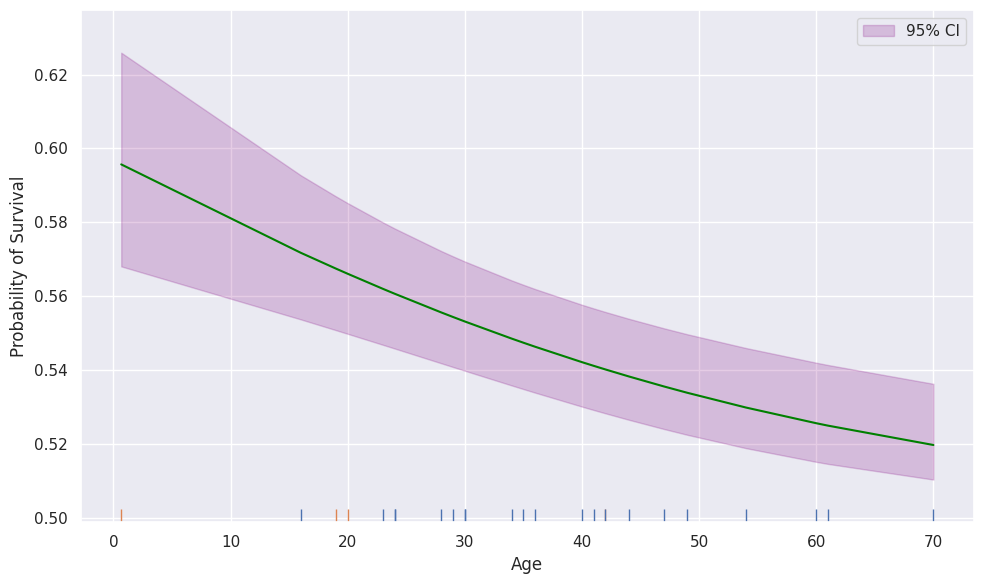

In [ ]:
# Generated solution

# Prepare sorted test data for smoother plots
data_test_select_sorted = data_test_select.sort_values('age_num')

# Get prediction and confidence intervals on the link scale
predictions = mod_1.get_prediction(data_test_select_sorted)
pred_summary = predictions.summary_frame()

data_test_select_sorted['fitted'] = ilink(pred_summary['mean'])
data_test_select_sorted['fit_ll'] = ilink(pred_summary['mean_ci_lower'])
data_test_select_sorted['fit_ul'] = ilink(pred_summary['mean_ci_upper'])

# Plot correctly transformed values
fig, ax = plt.subplots(figsize=(10, 6))

# Predicted probabilities and CI bands
sns.lineplot(x='age_num', y='fitted', data=data_test_select_sorted, color='green', ax=ax)
ax.fill_between(
    data_test_select_sorted['age_num'],
    data_test_select_sorted['fit_ll'],
    data_test_select_sorted['fit_ul'],
    color='purple', alpha=0.2, label='95% CI'
)

# Rug plot for actual data points by survival
sns.rugplot(x='age_num', hue='survived', data=data_test_select_sorted, ax=ax)

ax.set_xlabel('Age')
ax.set_ylabel('Probability of Survival')
ax.legend()

plt.tight_layout()
plt.show()


Why both plots differ?

### Binary classification & ROC curves

https://en.wikipedia.org/wiki/Binary_classification

https://en.wikipedia.org/wiki/Sensitivity_and_specificity

https://en.wikipedia.org/wiki/Receiver_operating_characteristic



Python resources

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/



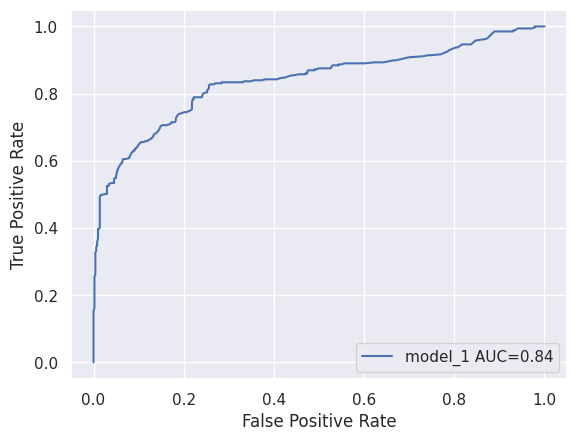

In [ ]:
fpr_m1, tpr_m1, thresholds_m1 = roc_curve(data_HW_mod.survived_num, data_HW_mod.fitted)
auc_m1 = roc_auc_score(data_HW_mod.survived_num, data_HW_mod.fitted)  # auc

plt.plot(fpr_m1,tpr_m1,label=f"model_1 AUC={round(auc_m1, 2)}")
plt.ylabel('True Positive Rate')  # aka sensitivity
plt.xlabel('False Positive Rate') # aka 1-specificity
plt.legend(loc=4)
plt.show()

In [ ]:
where = np.where((fpr > 0.0) & (fpr <= 0.1))[0]
pAUC = np.trapz(tpr[where], fpr[where], dx=0.01)  # 0.0-0.1 FPR
where2 = np.where((tpr > 0.9) & (tpr <= 1))[0]
pAUC2 = np.trapz(tpr[where2]-tpr[where2].min(), fpr[where2], dx=0.01)  # 0.9-1 TPR


NameError: name 'fpr' is not defined

In [ ]:

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')  # aka sensitivity
plt.xlabel('False Positive Rate') # aka 1-specificity

plt.fill_between(
        x= fpr[where2],
        y1= tpr[where2],
        y2 =tpr[where2].min(),
        color= "green",
        label=f'pAUC (0.9-1 TPR) \n {round(pAUC2, 2)}',  # partial auc
        alpha= 0.5)
plt.fill_between(
        x= fpr[where],
        y1= tpr[where],
        label=f'pAUC (0-0.1 FPR) \n {round(pAUC, 2)}',   # partial auc
        color= "purple",
        alpha= 0.5)
plt.legend(loc=4)
plt.show()

NameError: name 'fpr' is not defined

## Your Turn :

* Compute a new variable `nrelatives = sibsp + parch`
* Fit model with this new variable (you can try use it as continuous or as factor (change levels)) and `sex, age, fare, class, embarked`
* Try to use `step` function to find the "best" model.
* Validate the model. Are all variables significant? If you have any numerical variable, does it need any transformation?
* Plot densities of fitted probabilities for survived/not survived and choose optimal threshold.
* Compute the confusion matrix and basic statistics and compare results of your model with model mod_1
* Plot ROC curve of your model together with ROC curve of mod_1. Which one has larger AUC.

* Calibrate the output and show if its calibrated. Compare results with RF from scikit-learn

In [ ]:
#import necessary (and unnecessary) libraries
import numpy as np
import scipy
from scipy import stats
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay, roc_curve, \
     roc_auc_score, accuracy_score, precision_score, recall_score, auc



import matplotlib.pyplot as plt

from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import OLSInfluence

import seaborn as sns
sns.set_theme()

# Install R magic
!pip install -q rpy2

# Load R magic
%load_ext rpy2.ipython

In [ ]:
from pydoc import describe
X, y = datasets.fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X['nrelatives'] = X['sibsp'] + X['parch']

y = y.astype('float')
X.describe()

,pclass,age,sibsp,parch,fare,body,nrelatives
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000,1309.000000
mean,2.294882,29.881135,0.498854,0.385027,33.295479,160.809917,0.883881
std,0.837836,14.413500,1.041658,0.865560,51.758668,97.696922,1.583639
min,1.000000,0.166700,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800,72.000000,0.000000
50%,3.000000,28.000000,0.000000,0.000000,14.454200,155.000000,0.000000
75%,3.000000,39.000000,1.000000,0.000000,31.275000,256.000000,1.000000
max,3.000000,80.000000,8.000000,9.000000,512.329200,328.000000,10.000000


In [ ]:
data = pd.concat([X,y], axis = 1)
survival_by_relatives = data.groupby('nrelatives')['survived'].agg(['count','mean']).reset_index()
survival_by_relatives.columns = ['nrelatives','count','survivors/total number']
print(survival_by_relatives)

#based on the analysis of the dynamics of survival rate with respect to number of relatives, a decision to bin the nrelatives was made:
bins = [-0.1, 0.5, 2.5, 3.5, 6.5, 10.1]
labels = ['0', '1-2', '3', '4-6', '7-10']

# Apply binning
data['nrelatives_bin'] = pd.cut(data['nrelatives'], bins=bins, labels=labels)
data['nrelatives_bin'] = data['nrelatives_bin'].astype('category')


   nrelatives  count  survivors/total number
0           0    587                0.316865
1           1    206                0.548544
2           2    144                0.562500
3           3     39                0.769231
4           4     17                0.352941
5           5     25                0.200000
6           6     16                0.250000
7           7      8                0.000000
8          10      1                0.000000


Now let's fit the models in R

In [ ]:
data['pclass'].astype('category')
X_sel = data[['nrelatives_bin','nrelatives', 'sex', 'age', 'fare', 'pclass', 'embarked','survived']].dropna()
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

pandas2ri.activate()
ro.globalenv['X_sel'] = X_sel
ro.globalenv['y'] = X_sel['survived']

In [ ]:
%%R
df <- cbind(X_sel, survived = y)

full_model <- glm(survived ~ ., data = df, family = binomial)

# Stepwise selection
best_model <- step(full_model, direction = "both", trace = FALSE)

# Show summary
summary(best_model)


Call:
glm(formula = survived ~ nrelatives_bin + sex + age + pclass + 
    embarked, family = binomial, data = df)

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        1.740612  83.354562   0.021  0.98334    
nrelatives_bin.L  -9.913134 263.586668  -0.038  0.97000    
nrelatives_bin.Q  -8.116080 222.771518  -0.036  0.97094    
nrelatives_bin.C  -3.857816 131.793536  -0.029  0.97665    
nrelatives_bin^4  -0.710598  49.814650  -0.014  0.98862    
sexmale           -2.584345   0.180160 -14.345  < 2e-16 ***
age               -0.034188   0.006707  -5.097 3.45e-07 ***
pclass            -0.936552   0.118880  -7.878 3.32e-15 ***
embarkedQ         -1.350525   0.449898  -3.002  0.00268 ** 
embarkedS         -0.677227   0.208688  -3.245  0.00117 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1409.99  on 1042  degrees of freedom
Residual deviance:  942.05  

In addition: Warning messages:
1: In model.matrix.default(mt, mf, contrasts) :
  the response appeared on the right-hand side and was dropped
2: In model.matrix.default(mt, mf, contrasts) :
  problem with term 8 in model.matrix: no columns are assigned
3: In model.matrix.default(object, data = list(survived = c(1, 1, 0,  :
  the response appeared on the right-hand side and was dropped
4: In model.matrix.default(object, data = list(survived = c(1, 1, 0,  :
  problem with term 8 in model.matrix: no columns are assigned
5: In model.matrix.default(Terms, m, contrasts.arg = object$contrasts) :
  the response appeared on the right-hand side and was dropped
6: In model.matrix.default(Terms, m, contrasts.arg = object$contrasts) :
  problem with term 8 in model.matrix: no columns are assigned
7: In model.matrix.default(Terms, m, contrasts.arg = object$contrasts) :
  the response appeared on the right-hand side and was dropped
8: In model.matrix.default(Terms, m, contrasts.arg = object$contrasts

get back to Python

In [ ]:
opt_model = smf.glm('survived ~ nrelatives_bin + sex + age + C(pclass) + embarked', data=X_sel, family=sm.families.Binomial()).fit()
print(opt_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               survived   No. Observations:                 1043
Model:                            GLM   Df Residuals:                     1032
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -470.65
Date:                Tue, 29 Apr 2025   Deviance:                       941.29
Time:                        19:22:37   Pearson chi2:                 1.10e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.3620
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3

In [ ]:
# lets test whether the nrelatives variable is really significant in the model
red_model = smf.glm('survived ~ sex + age + pclass + embarked', data=X_sel, family=sm.families.Binomial()).fit()
# Likelihood Ratio Test
llf_reduced = red_model.llf  # log-likelihood of reduced model
llf_full = opt_model.llf        # log-likelihood of full model

lr_stat = 2 * (llf_full - llf_reduced)  # test statistic
df_diff = opt_model.df_model - red_model.df_model  # degrees of freedom
p_value = stats.chi2.sf(lr_stat, df_diff)
print(f"p-value: {p_value}")

p-value: 0.00014254926740887315


despite high p-values of z-statistics, the likelihood ratio test shows that the full model with nrelatives variable is significantly better

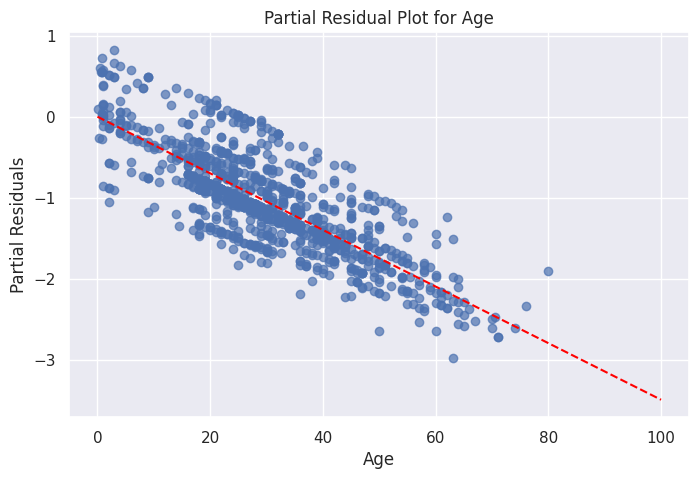

In [ ]:
# The only continuous variable here is age and pclass, so lets make a partial residual plot whether the relationship on age is really linear
partial_resid = opt_model.resid_response + opt_model.params['age'] * X_sel['age']

# Plot: age vs. partial residuals
plt.figure(figsize=(8, 5))
plt.scatter(X_sel['age'], partial_resid, alpha=0.7)
plt.plot(np.linspace(0, 100, 100*10), opt_model.params['age'] * np.linspace(0,100, 100*10), color='red', linestyle='--')
plt.xlabel('Age')
plt.ylabel('Partial Residuals')
plt.title('Partial Residual Plot for Age')
plt.grid(True)
plt.show()

It does not look that the should be some non-linear relationship between age and log odds

<ipython-input-201-e6c7535e9ceb>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_sel[X_sel['survived'] == 1]['fitted_prob'], label='Survived', shade=True, color='green')
<ipython-input-201-e6c7535e9ceb>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_sel[X_sel['survived'] == 0]['fitted_prob'], label='Did Not Survive', shade=True, color='red')


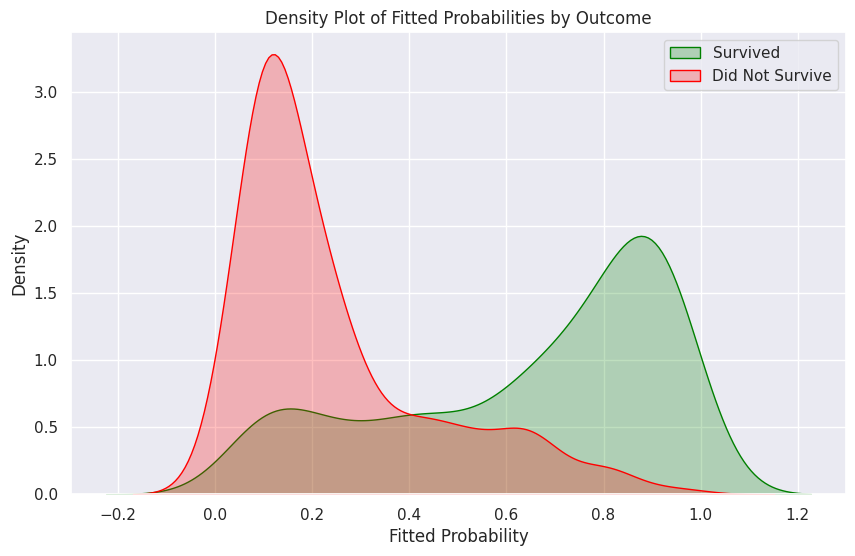

In [ ]:
fitted_probs_opt = opt_model.predict(X_sel)

# Add them to the original DataFrame
X_sel['fitted_prob'] = fitted_probs_opt
X_sel['survived'] = y  # Make sure this column is aligned with X used in model

# Plot densities
plt.figure(figsize=(10, 6))
sns.kdeplot(X_sel[X_sel['survived'] == 1]['fitted_prob'], label='Survived', shade=True, color='green')
sns.kdeplot(X_sel[X_sel['survived'] == 0]['fitted_prob'], label='Did Not Survive', shade=True, color='red')
plt.xlabel('Fitted Probability')
plt.ylabel('Density')
plt.title('Density Plot of Fitted Probabilities by Outcome')
plt.legend()
plt.grid(True)
plt.show()

p = 0.44 was selected as an optimal threshold


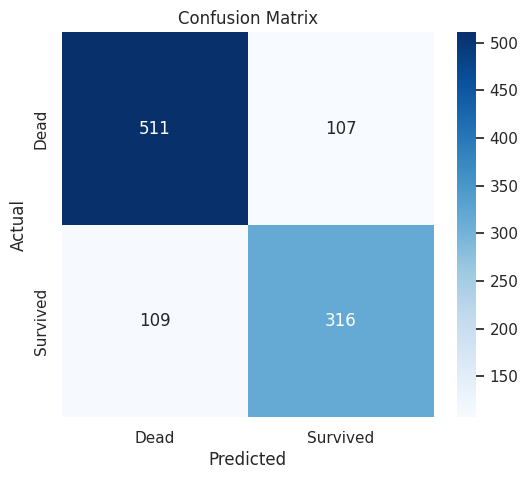

In [ ]:
y_pred = (fitted_probs_opt >= 0.44).astype(int)  # 1 for survived, 0 for dead
y = X_sel['survived']
# Calculate confusion matrix
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Dead", "Survived"], yticklabels=["Dead", "Survived"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.7929
Precision: 0.7470
Recall: 0.7435


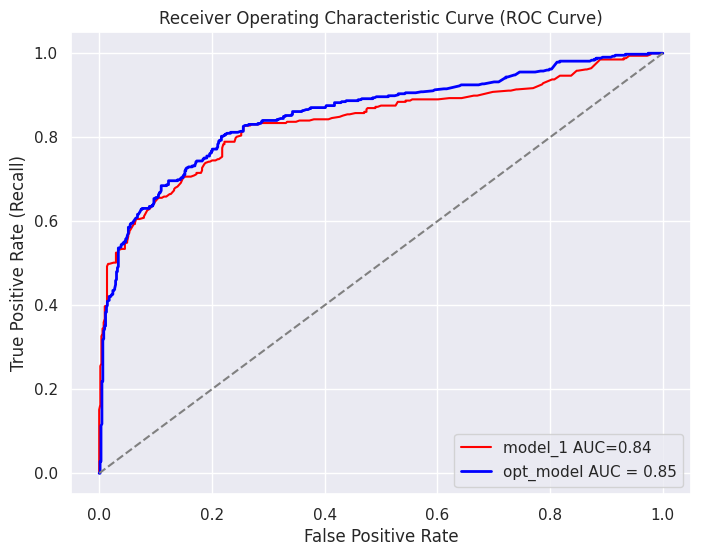

In [ ]:
fpr_opt, tpr_opt, thresholds = roc_curve(y, fitted_probs_opt)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr_opt, tpr_opt)

#load model_1 roc curve
fpr_m1, tpr_m1, thresholds_m1 = roc_curve(data_HW_mod.survived_num, data_HW_mod.fitted)
auc_m1 = roc_auc_score(data_HW_mod.survived_num, data_HW_mod.fitted)  # auc


# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_m1,tpr_m1, color = 'red',label=f"model_1 AUC={round(auc_m1, 2)}")
plt.plot(fpr_opt, tpr_opt, color='blue', lw=2, label=f'opt_model AUC = {round(roc_auc, 2)}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal (Random Guess)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic Curve (ROC Curve)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

<ipython-input-205-284e958ea7c1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probabilities['Decile'] = pd.qcut(probabilities.iloc[:,1], 10, labels=False)


<Figure size 1000x600 with 0 Axes>

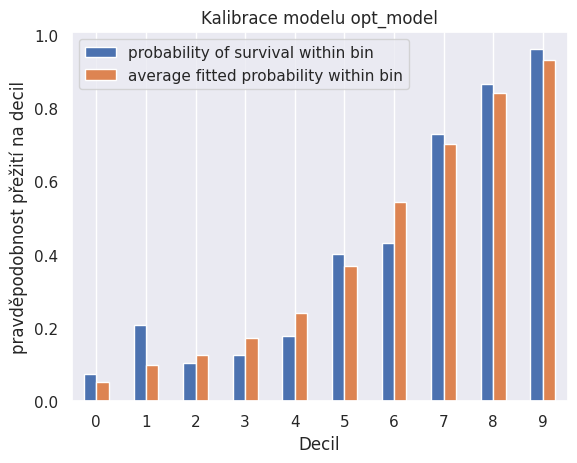

In [ ]:
probabilities = X_sel[['survived','fitted_prob']]

 # Create deciles for Column2

probabilities['Decile'] = pd.qcut(probabilities.iloc[:,1], 10, labels=False)

# Calculate average of Column1 per decile
average_per_decile = probabilities.groupby('Decile')[['survived', 'fitted_prob']].mean()
average_per_decile.columns = ['probability of survival within bin', 'average fitted probability within bin']

# Plotting
plt.figure(figsize=(10, 6))
average_per_decile.plot(kind='bar')
plt.title('Kalibrace modelu opt_model')
plt.xlabel('Decil')
plt.ylabel('pravděpodobnost přežití na decil')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

<ipython-input-206-764aa8192783>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probabilities['probability_bins'] = pd.cut(probabilities.iloc[:,1], bins = bins, labels=labels)
<ipython-input-206-764aa8192783>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_per_decile = probabilities.groupby('probability_bins')[['survived', 'fitted_prob']].mean()


<Figure size 1000x600 with 0 Axes>

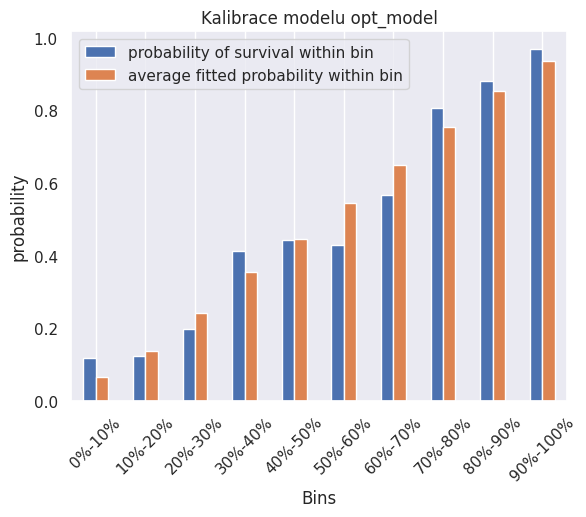

In [ ]:
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

labels = ['0%-10%','10%-20%', '20%-30%', '30%-40%', '40%-50%', '50%-60%', '60%-70%', '70%-80%', '80%-90%', '90%-100%' ]

# Create deciles for Column2
probabilities['probability_bins'] = pd.cut(probabilities.iloc[:,1], bins = bins, labels=labels)

# Calculate average of Column1 per decile
average_per_decile = probabilities.groupby('probability_bins')[['survived', 'fitted_prob']].mean()
average_per_decile.columns = ['probability of survival within bin', 'average fitted probability within bin']

# Plotting
plt.figure(figsize=(10, 6))
average_per_decile.plot(kind='bar')
plt.title('Kalibrace modelu opt_model')
plt.xlabel('Bins')
plt.ylabel('probability')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()

In [ ]:
cont_model = smf.glm('survived ~ nrelatives + I(nrelatives ** 2)+ sex + age + C(pclass) + embarked', data=X_sel, family=sm.families.Binomial()).fit()
print(cont_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               survived   No. Observations:                 1043
Model:                            GLM   Df Residuals:                     1034
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -474.12
Date:                Tue, 29 Apr 2025   Deviance:                       948.24
Time:                        20:48:51   Pearson chi2:                 1.07e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3577
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.8785      0

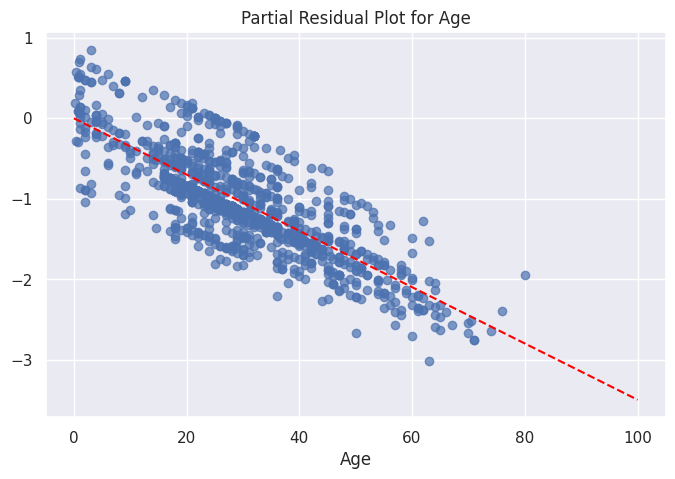

In [ ]:
# The only continuous variable here are age and nrelatives, so lets make a partial residual plot whether the relationship on age is really linear
partial_resid = cont_model.resid_response + cont_model.params['age'] * X_sel['age']

# Plot: age vs. partial residuals
plt.figure(figsize=(8, 5))
plt.scatter(X_sel['age'], partial_resid, alpha=0.7)
plt.plot(np.linspace(0, 100, 100*10), opt_model.params['age'] * np.linspace(0,100, 100*10), color='red', linestyle='--')
plt.xlabel('Age')
plt.title('Partial Residual Plot for Age')
plt.grid(True)
plt.show()

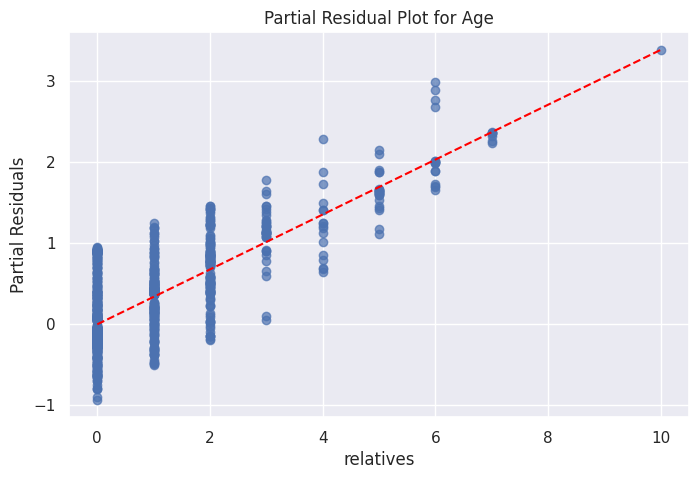

In [ ]:
# The only continuous variable here are age and pclass, so lets make a partial residual plot whether the relationship on age is really linear
partial_resid = cont_model.resid_response + cont_model.params['nrelatives'] * X_sel['nrelatives']

# Plot: age vs. partial residuals
plt.figure(figsize=(8, 5))
plt.scatter(X_sel['nrelatives'], partial_resid, alpha=0.7)
plt.plot(np.linspace(0, 10, 100), cont_model.params['nrelatives']*np.linspace(0,10, 100), color='red', linestyle='--')
plt.xlabel('relatives')
plt.ylabel('Partial Residuals')
plt.title('Partial Residual Plot for Age')
plt.grid(True)
plt.show()

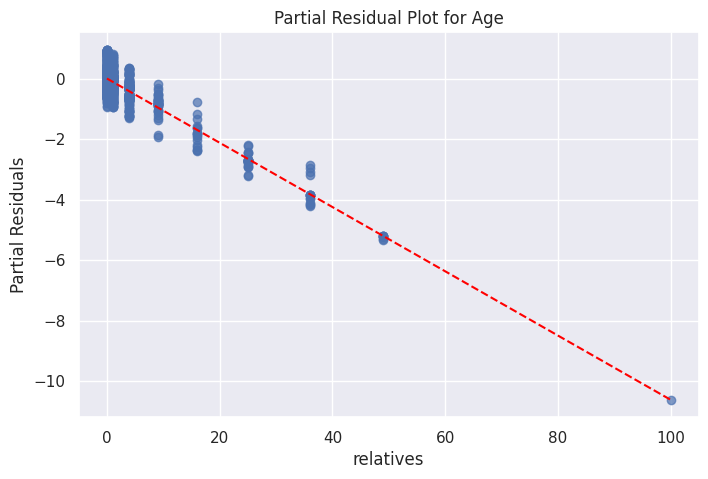

In [ ]:
# The only continuous variable here are age and pclass, so lets make a partial residual plot whether the relationship on age is really linear
partial_resid = cont_model.resid_response + cont_model.params['I(nrelatives ** 2)'] * X_sel['nrelatives'] **2

# Plot: age vs. partial residuals
plt.figure(figsize=(8, 5))
plt.scatter(X_sel['nrelatives']**2, partial_resid, alpha=0.7)
plt.plot(np.linspace(0, 100, 1000), cont_model.params['I(nrelatives ** 2)']*np.linspace(0,100, 1000), color='red', linestyle='--')
plt.xlabel('relatives')
plt.ylabel('Partial Residuals')
plt.title('Partial Residual Plot for Age')
plt.grid(True)
plt.show()

<ipython-input-211-c4aa4bfff5c5>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_sel[X_sel['survived'] == 1]['fitted_prob'], label='Survived', shade=True, color='green')
<ipython-input-211-c4aa4bfff5c5>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_sel[X_sel['survived'] == 0]['fitted_prob'], label='Did Not Survive', shade=True, color='red')


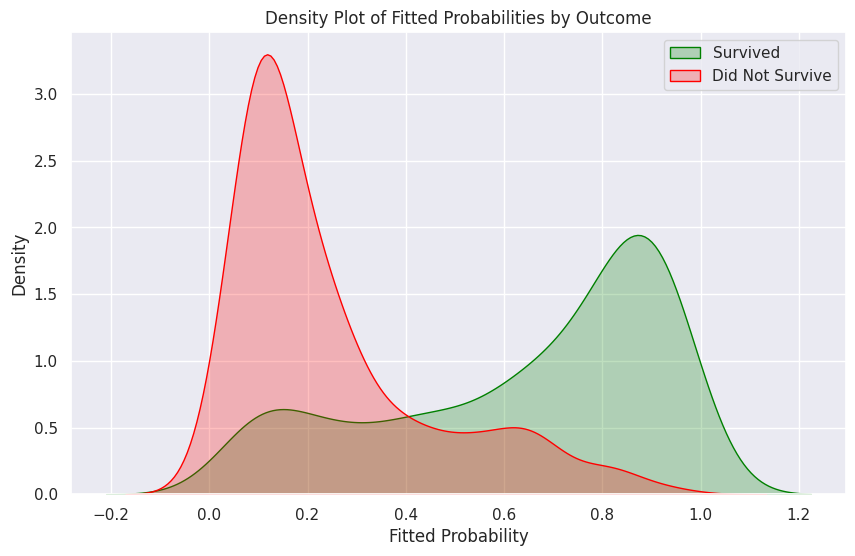

In [ ]:
fitted_probs_cont = cont_model.predict(X_sel)

# Add them to the original DataFrame
X_sel['fitted_prob'] = fitted_probs_cont
X_sel['survived'] = y  # Make sure this column is aligned with X used in model

# Plot densities
plt.figure(figsize=(10, 6))
sns.kdeplot(X_sel[X_sel['survived'] == 1]['fitted_prob'], label='Survived', shade=True, color='green')
sns.kdeplot(X_sel[X_sel['survived'] == 0]['fitted_prob'], label='Did Not Survive', shade=True, color='red')
plt.xlabel('Fitted Probability')
plt.ylabel('Density')
plt.title('Density Plot of Fitted Probabilities by Outcome')
plt.legend()
plt.grid(True)
plt.show()

0      -0.004507
1      -0.139121
2      -0.019485
3      -0.186914
4      -0.041618
          ...   
1301   -0.005375
1304    0.004796
1306   -0.007219
1307   -0.007177
1308   -0.002905
Length: 1043, dtype: float64


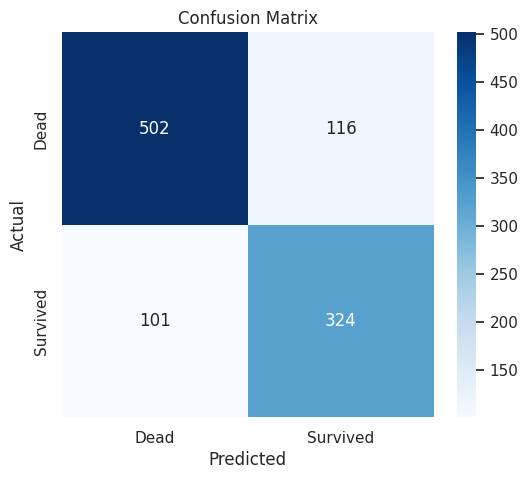

In [ ]:
y_pred = (fitted_probs_cont >= 0.41).astype(int)  # 1 for survived, 0 for dead
y = X_sel['survived']
# Calculate confusion matrix
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Dead", "Survived"], yticklabels=["Dead", "Survived"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.7919
Precision: 0.7364
Recall: 0.7624


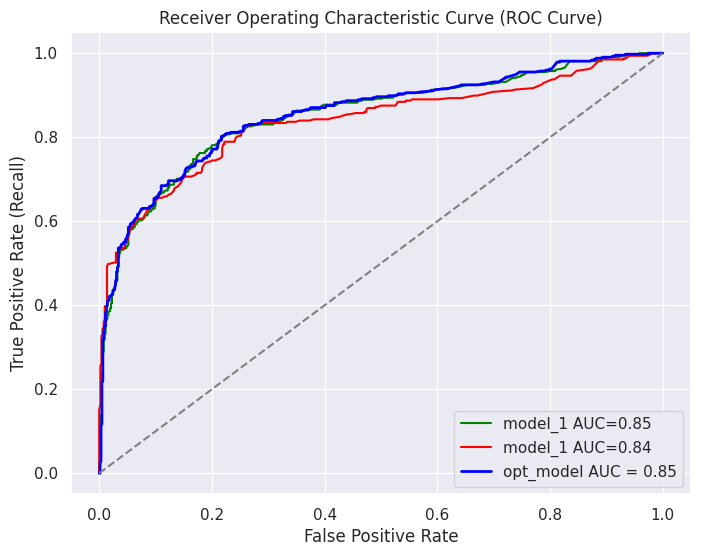

In [ ]:
fpr_cont, tpr_cont, thresholds = roc_curve(y, fitted_probs_cont)

# Calculate AUC (Area Under the Curve)
roc_cont = auc(fpr_cont, tpr_cont)

#load model_1 roc curve
fpr_m1, tpr_m1, thresholds_m1 = roc_curve(data_HW_mod.survived_num, data_HW_mod.fitted)
auc_m1 = roc_auc_score(data_HW_mod.survived_num, data_HW_mod.fitted)  # auc


# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_cont,tpr_cont, color = 'green',label=f"model_1 AUC={round(roc_cont, 2)}")
plt.plot(fpr_m1,tpr_m1, color = 'red',label=f"model_1 AUC={round(auc_m1, 2)}")
plt.plot(fpr_opt, tpr_opt, color='blue', lw=2, label=f'opt_model AUC = {round(roc_auc, 2)}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal (Random Guess)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic Curve (ROC Curve)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



<ipython-input-219-f4a5cb813acf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probabilities['Decile'] = pd.qcut(probabilities.iloc[:,1], 10, labels=False)


<Figure size 1000x600 with 0 Axes>

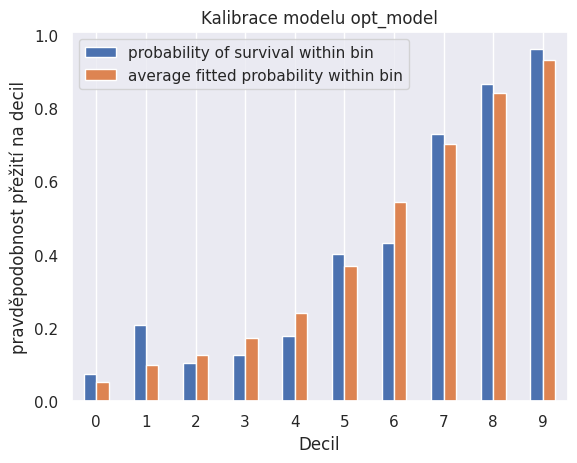

In [ ]:
 # Create deciles for fitted probabilities
probabilities['Decile'] = pd.qcut(probabilities.iloc[:,1], 10, labels=False)

# Calculate average of Column1 per decile
average_per_decile = probabilities.groupby('Decile')[['survived', 'fitted_prob']].mean()
average_per_decile.columns = ['probability of survival within bin', 'average fitted probability within bin']

# Plotting
plt.figure(figsize=(10, 6))
average_per_decile.plot(kind='bar')
plt.title('Kalibrace modelu opt_model')
plt.xlabel('Decil')
plt.ylabel('pravděpodobnost přežití na decil')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

<ipython-input-220-174df5402159>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probabilities['Decile'] = pd.qcut(probabilities.iloc[:,1], 10, labels=False)


<Figure size 1000x600 with 0 Axes>

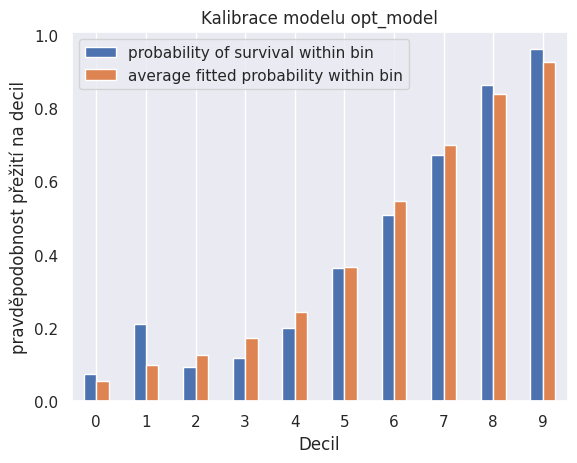

In [ ]:
X_sel['fitted_prob'] = fitted_probs_cont
probabilities = X_sel[['survived','fitted_prob']]

 # Create deciles for Column2

probabilities['Decile'] = pd.qcut(probabilities.iloc[:,1], 10, labels=False)

# Calculate average of Column1 per decile
average_per_decile = probabilities.groupby('Decile')[['survived', 'fitted_prob']].mean()
average_per_decile.columns = ['probability of survival within bin', 'average fitted probability within bin']

# Plotting
plt.figure(figsize=(10, 6))
average_per_decile.plot(kind='bar')
plt.title('Kalibrace modelu opt_model')
plt.xlabel('Decil')
plt.ylabel('pravděpodobnost přežití na decil')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

<ipython-input-221-764aa8192783>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probabilities['probability_bins'] = pd.cut(probabilities.iloc[:,1], bins = bins, labels=labels)
<ipython-input-221-764aa8192783>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_per_decile = probabilities.groupby('probability_bins')[['survived', 'fitted_prob']].mean()


<Figure size 1000x600 with 0 Axes>

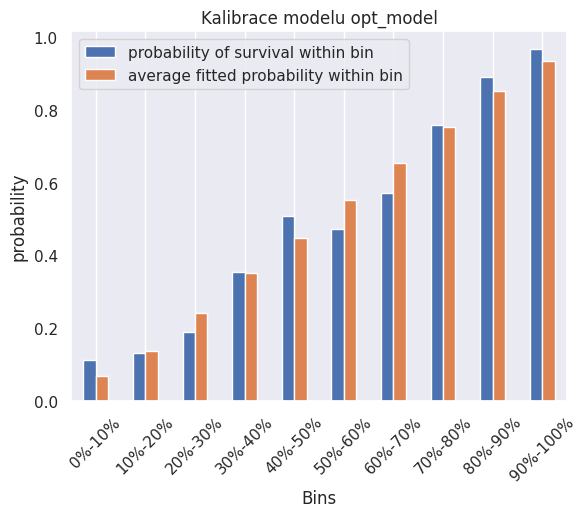

In [ ]:
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

labels = ['0%-10%','10%-20%', '20%-30%', '30%-40%', '40%-50%', '50%-60%', '60%-70%', '70%-80%', '80%-90%', '90%-100%' ]

# Create deciles for Column2
probabilities['probability_bins'] = pd.cut(probabilities.iloc[:,1], bins = bins, labels=labels)

# Calculate average of Column1 per decile
average_per_decile = probabilities.groupby('probability_bins')[['survived', 'fitted_prob']].mean()
average_per_decile.columns = ['probability of survival within bin', 'average fitted probability within bin']

# Plotting
plt.figure(figsize=(10, 6))
average_per_decile.plot(kind='bar')
plt.title('Kalibrace modelu opt_model')
plt.xlabel('Bins')
plt.ylabel('probability')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()